# Extracción de datos

In [ ]:
# Para la extracción de datos trabajaré en R
%load_ext rpy2.ipython

In [ ]:
%%R
# Instalo paquetes y llamo a las librerías necesarias
# Utilizaré un paquete diseñado para extraer estadísticas de jugadores de futbol, partidos, etc. de las webs FBref, Transfermarkt y Understat.
# En mi caso particular, necesito las funciones de Transfermarkt, detalladas en el siguiente link: https://jaseziv.github.io/worldfootballR/articles/extract-transfermarkt-data.html
install.packages("devtools")
devtools::install_github("JaseZiv/worldfootballR")
library(worldfootballR)
library(dplyr)
library(purrr)
library(tibble)
library(readr)
library(httr)

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpCY7o9w/remotes1bf2121f3d4/JaseZiv-worldfootballR-4bbc357/DESCRIPTION’ ... OK
* preparing ‘worldfootballR’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
  NB: this package now depends on R (>= 4.2.0)
  pipe placeholder syntax added in R 4.2.0
  File(s) using such syntax:
    ‘player_market_values.R’
* building ‘worldfootballR_0.6.8.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/devtools_2.4.5.tar.gz'
Content type 'application/x-gzip' length 374718 bytes (365 KB)
downloaded 365 KB


The downloaded source packages are in
	‘/tmp/RtmpCY7o9w/downloaded_packages’
Installing 3 packages: snakecase, qdapRegex, janitor
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/snakecase_0.11.1.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/qdapRegex_0.7.10.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/janitor_2.2.1.tar.gz'

The downloaded source packages are in
	‘/tmp/RtmpCY7o9w/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect,

In [ ]:
%%R
# Función para manejar errores y reintentos. Se colocan 7 ya que en el proceso de extracción se verificaron hasta 5 o 6 intentos fallidos
safe_extract <- function(func, ..., max_retries = 7) {
  for (i in 1:max_retries) {
    tryCatch({
      result <- func(...)
      return(result)
    }, error = function(e) {
      message(paste("Error en intento", i, ":", e$message))
      if (i < max_retries) {
        Sys.sleep(2^i)
      } else {
        warning(paste("Fallo después de", max_retries, "intentos"))
        return(NULL)
      }
    })
  }
}

##Estadísticas jugadores

In [ ]:
%%R
# En primera instancia obtengo el dato de todos los jugadores que han jugado en las 5 ligas top europeas para las temporadas 2020 a 2024
# La extracción de datos se hizo mediante RStudio, lo cual agilizó el proceso y permitió ir corroborando su progresión a medida que avanzaba la descarga de datos.
# No obstante, en la presente celda se corrobora que exista el archivo que se subió a Github, y de lo contrario comienza a screaper nuevamente.
url_github <- "https://raw.githubusercontent.com/FranMoretti/TFI_Lesiones_Futbol/refs/heads/main/estadisticas_jugadores.csv"

if (http_error(url_github)) {

  paises <- c("England", "Spain", "Italy", "Germany", "France")
  nombres_ligas <- c("Premier League", "La Liga", "Serie A", "Bundesliga", "Ligue 1")
  temporadas <- 2020:2024

  all_squad_data <- list()

  # Función
  procesar_liga_temporada <- function(pais, liga_nombre, temporada) {
    message(paste("\n Procesando:", liga_nombre, "-", temporada))

    team_urls <- safe_extract(tm_league_team_urls,
                              country_name = pais,
                              start_year = temporada)

    if (is.null(team_urls) || length(team_urls) == 0) {
      message(paste("X No se pudieron obtener equipos de", liga_nombre, temporada))
      return(NULL)
    }

    squad_data <- safe_extract(tm_squad_stats,
                               team_url = team_urls)

    if (is.null(squad_data) || nrow(squad_data) == 0) {
      message(paste("X No se pudieron obtener estadísticas de", liga_nombre, temporada))
      return(NULL)
    }

    squad_data_complete <- squad_data %>%
      mutate(
        pais = pais,
        liga = liga_nombre,
        temporada = temporada,
      ) %>%
      select(pais, liga, temporada, everything())

    equipos_procesados <- length(unique(squad_data_complete$squad))
    jugadores_totales <- nrow(squad_data_complete)

    message(paste("OK", jugadores_totales, "jugadores"))

    return(squad_data_complete)
  }

  # Proceso
  message("\n Iniciando descarga de datos para 5 ligas principales")
  total_combinaciones <- length(paises) * length(temporadas)
  contador <- 0

  for (i in seq_along(paises)) {
    pais <- paises[i]
    liga_nombre <- nombres_ligas[i]

    for (temporada in temporadas) {
      contador <- contador + 1
      message(paste("\n Progreso:", contador, "/", total_combinaciones))

      resultado <- procesar_liga_temporada(pais, liga_nombre, temporada)

      if (!is.null(resultado)) {
        clave <- paste(pais, temporada, sep = "_")
        all_squad_data[[clave]] <- resultado
      }

      if (temporada < max(temporadas)) {
        Sys.sleep(10)
      }
    }

    if (i < length(paises)) {
      message("\n Pausa más larga entre países...")
      Sys.sleep(20)
    }
  }

  # Guardado
  if (length(all_squad_data) > 0) {
    final_dataset <- bind_rows(all_squad_data)

    write_csv(final_dataset, "COMPLETO_top5_ligas_2020_2024.csv")
    message(" Dataset completo guardado: COMPLETO_top5_ligas_2020_2024.csv")

  } else {
    message("X No se pudo descargar ningún dato.")
  }

} else {
  message("✔ El archivo ya existe en GitHub. No se realizará el scrapeo.")
}

✔ El archivo ya existe en GitHub. No se realizará el scrapeo.


## Lesiones

In [ ]:
# Tomo la URL de los jugadores, elimino duplicados, y uso la variable player_url para traerme todas las lesiones que han tenido esos jugadores
%%R
library(httr)
library(readr)
library(dplyr)

# Verificación: si el archivo YA existe en GitHub, NO ejecuta el proceso
url_injuries <- "https://raw.githubusercontent.com/FranMoretti/TFI_Lesiones_Futbol/refs/heads/main/lesiones_scrapeadas.csv"

if (http_error(url_injuries)) {

  df2 <- readr::read_csv("https://raw.githubusercontent.com/FranMoretti/TFI_Lesiones_Futbol/refs/heads/main/estadisticas_jugadores.csv")
  message("Dimensiones de df2: ", paste(dim(df2), collapse = " x "))
  head(df2)

  player_urls <- df2 %>%
    select(player_url) %>%
    distinct()

  message(paste("Total de URLs únicas:", nrow(player_urls)))

  extract_injuries_batch <- function(player_urls_batch, batch_name) {
    message(paste("Procesando lote:", batch_name))
    injuries <- safe_extract(tm_player_injury_history, player_urls = player_urls_batch)
    if (!is.null(injuries)) {
      message(paste("OK.", nrow(injuries), "lesiones extraídas"))
    } else {
      message(paste("X Error en lote", batch_name))
    }
    return(injuries)
  }

  batch_size <- 100
  player_batches <- split(player_urls$player_url,
                          ceiling(seq_along(player_urls$player_url) / batch_size))

  all_injuries_list <- list()

  for (i in seq_along(player_batches)) {
    batch_name <- paste("Lote", i, "de", length(player_batches))
    injuries <- extract_injuries_batch(player_batches[[i]], batch_name)

    if (!is.null(injuries)) {
      all_injuries_list[[i]] <- injuries
    }

    Sys.sleep(10)

    if (i %% 5 == 0) {
      temp_injuries <- bind_rows(all_injuries_list)
      saveRDS(temp_injuries, paste0("injuries_progress_", i, ".rds"))
      message(paste("Backup guardado tras lote", i))
    }
  }

  # Archivo final
  final_injuries <- bind_rows(all_injuries_list)
  write.csv(final_injuries, "lesiones_scrapeadas.csv", row.names = FALSE)
  message("Archivo final 'lesiones_scrapeadas.csv' guardado.")

} else {
  message("✔ El archivo 'lesiones_scrapeadas.csv' ya existe en GitHub. No se realizará el scrapeo.")
}

✔ El archivo 'lesiones_scrapeadas.csv' ya existe en GitHub. No se realizará el scrapeo.


#Imports

In [90]:
# Efectúo todos los imports necesarios
#EDA
import pandas as pd
import numpy as np
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import duckdb
import seaborn as sns
from vega_datasets import data
from seaborn import boxplot
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

#Modelos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, classification_report, silhouette_score, precision_recall_fscore_support, precision_score, precision_recall_curve, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
!pip install catboost
from catboost import CatBoostClassifier
import joblib
import urllib.request
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import re
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Análisis Exploratorio de Datos

##Jugadores

In [2]:
# A partir de aquí trabajaré con python
url_jugadores = "https://raw.githubusercontent.com/FranMoretti/TFI_Lesiones_Futbol/refs/heads/main/estadisticas_jugadores.csv"
df_jugadores = pd.read_csv(url_jugadores)
print(f"Filas: {df_jugadores.shape[0]}, Columnas: {df_jugadores.shape[1]}")
df_jugadores.head(3)

Filas: 18787, Columnas: 15


pais            liga  temporada  ... appearances goals minutes_played
0  England  Premier League       2020  ...           0     0              0
1  England  Premier League       2020  ...          48     0           4320
2  England  Premier League       2020  ...          12     0           1080

[3 rows x 15 columns]

In [3]:
df_jugadores[df_jugadores['player_url'] == 'https://www.transfermarkt.com/valentin-barco/profil/spieler/849410']

pais            liga  temporada  ... appearances goals minutes_played
2817   England  Premier League       2023  ...           7     0            318
3665   England  Premier League       2024  ...           0     0              0
7479     Spain         La Liga       2024  ...           9     0            466
18298   France         Ligue 1       2024  ...          15     0           1199

[4 rows x 15 columns]

In [4]:
df_jugadores.tail(3)

pais     liga  temporada  ... appearances goals minutes_played
18784  France  Ligue 1       2024  ...           2     0             25
18785  France  Ligue 1       2024  ...           0     0              0
18786  France  Ligue 1       2024  ...           2     0              7

[3 rows x 15 columns]

In [5]:
print(f"Jugadores únicos: {df_jugadores['player_url'].nunique()}")

Jugadores únicos: 7863


A priori ya se observa que tenemos 18.787 registros con 15 variables, correspondientes a 7.863 jugadores. No solo habrá 1 registro por cada jugador y temporada, sino que se puede dar el caso de jugadores que en una misma temporada pasaron por dos equipos diferentes, dando como resultado 2 registros diferentes. Las primeras 3 variables (país, liga, temporada) fueron creadas por mi, y las restantes las que se obtienen de la función de la librería que scrapea.

In [6]:
df_jugadores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18787 entries, 0 to 18786
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   pais            18787 non-null  object
 1   liga            18787 non-null  object
 2   temporada       18787 non-null  int64 
 3   team_name       18787 non-null  object
 4   league          18787 non-null  object
 5   country         18787 non-null  object
 6   player_name     18787 non-null  object
 7   player_url      18787 non-null  object
 8   player_pos      18787 non-null  object
 9   player_age      18787 non-null  int64 
 10  nationality     18787 non-null  object
 11  in_squad        18787 non-null  int64 
 12  appearances     18787 non-null  int64 
 13  goals           18787 non-null  int64 
 14  minutes_played  18787 non-null  int64 
dtypes: int64(6), object(9)
memory usage: 2.2+ MB


De las 15 variables, 9 son tipo object y las restantes 6 numéricas tipo entero.

In [7]:
# Comenzaré analiando cuantos jugadores existen por liga, tomando la variable 'league', descargada por defecto con al función de la librería JaseZiv/worldfootballR
df_league_count = df_jugadores.groupby('league')['player_url'].nunique().reset_index()
df_league_count = df_league_count.rename(columns={'player_url': 'Cantidad'})
alt.Chart(df_league_count).mark_bar().encode(
    x='Cantidad:Q',
    y=alt.Y('league:N').sort('-x'),
    tooltip=['league:N', 'Cantidad:Q']
).properties(title="Jugadores por liga")

alt.Chart(...)

Sorprendentemente figuran ligas de 2da o incluso 3ra categoría de alguno de los países.

In [8]:
# A continuación inspeccionaré uno de los casos
df_jugadores[df_jugadores['league'] == '2. Bundesliga'].head(1)

pais        liga  temporada  ... appearances goals minutes_played
12318  Germany  Bundesliga       2020  ...           0     0              0

[1 rows x 15 columns]

Por ejemplo, al tomar el caso 'team_name' == Hertha BSC se corrobora que en el año 2020 jugó en la 'Bundesliga' (1ra división alemana), pero actualmente milita en la 2da divisón. Por lo cual, se podría inferir que la función que scrapea te trae correctamente los datos del equipo de 2020, pero en la variable 'league' asigna según su valor actual y no el histórico del momento consultado.

In [9]:
# Ahora con el equipo en la 3ra de Italia
df_jugadores[df_jugadores['league'] == 'Serie C - Girone C'].head(1)

pais     liga  temporada  ... appearances goals minutes_played
8672  Italy  Serie A       2020  ...           2     0            210

[1 rows x 15 columns]

Lo mismo para 'team_name' == FC Crotone, que en 2020 estaba en la Serie A y actualmente milita en la Serie C.

In [10]:
# Para confirmar esto graficaré cuantos equipos hay por temporada y liga
duckdb.register('df_jugadores_db', df_jugadores)
consulta_sql = """
SELECT
    country,
    temporada,
    COUNT(DISTINCT team_name) AS num_teams
FROM df_jugadores_db
GROUP BY country, temporada
ORDER BY country, temporada
"""
cuadro_equipos_sql = duckdb.sql(consulta_sql).df()
cuadro_equipos = cuadro_equipos_sql.pivot(index='country', columns='temporada', values='num_teams')
cuadro_equipos_reset = cuadro_equipos.reset_index()
cuadro_equipos_melt = cuadro_equipos_reset.melt(id_vars='country', var_name='temporada', value_name='equipos')
cuadro_equipos_melt['equipos'] = cuadro_equipos_melt['equipos'].astype(int)
chart = alt.Chart(cuadro_equipos_melt).mark_rect().encode(alt.X('temporada:O'),alt.Y('country:N'),alt.Color('equipos:O', title='Cant.', scale=alt.Scale(scheme='blues'))
).properties(width=200, height=200, title='Cantidad de equipos por país y temporada')
chart

alt.Chart(...)

Evidentemente la hipótesis es correcta dado que se visualiza que en todos los casos el total de equipos por temporada es correcto, excepto por Francia. Aquí se presenta la particularidad que hasta 2022 esa liga tuvo 20 equipos y luego disminuyó a 18, por lo cual las únicas temporadas incompletas serían la 2020 y 2021. Investigando sobre los 3 casos faltantes, se corresponden a 2 equipos: Girondins Bordeaux que en 2020 y 2021 supo jugar en 1ra y que ahora milita en la 4ª categoría y Nîmes Olympique en 2020 también, que ahora juega en la 6ª categoría. Es factible que no haya levantado el dato por casos especiales que ya pertenecen a ligas semiprofesionales o que cambió algo en su estructura de datos o url.

In [11]:
# Elimino la variable 'pais' (creada por mi al momento de la extracción de datos) dado que se encuentra repetida ('country')
# También elimino 'league' porque refleja el dato actual donde milita el equipo, y prefiero quedarme con la creada por mi 'liga', la cual refleja el dato histórico (dónde jugó en determinado año)
df_jugadores = df_jugadores.drop(columns=['pais', 'league'])
df_jugadores.head(1)

liga  temporada  ... goals minutes_played
0  Premier League       2020  ...     0              0

[1 rows x 13 columns]

In [12]:
alt.data_transformers.disable_max_rows()
alt.Chart(df_jugadores).mark_bar().encode(
    alt.X("player_age:Q", bin=alt.Bin(maxbins=30), title='Edad'),
    y=alt.Y('count()', title='cantidad de jugadores'), tooltip=[alt.Tooltip('count()', title='cantidad')]
)

Output hidden; open in https://colab.research.google.com to view.

La mayor concentración de jugadores se encuentra entre lo que serían los 18 y 26 años aproximadamente, con un pico máximo alrededor de los 18/20 años apenas por debajo de los 1.500 jugadores. A partir de los 25/26 años, se observa una disminución progresiva y constante en la frecuencia, evidenciando que hay significativamente menos jugadores conforme aumenta la edad. La distribución es asimétrica hacia la derecha, con muy pocos jugadores menores de 16 años y una cola que se extiende hasta aproximadamente los 42 años.

In [13]:
alt.Chart(df_jugadores).mark_boxplot().encode(
    x=alt.X('player_age:Q',title='Edad'),
    y=alt.Y('liga:N', title='Liga')
).properties(width=350, height=200)

Output hidden; open in https://colab.research.google.com to view.

En el boxplot de la edad de los jugadores comparativo por liga, muestra nuevamente una distribución asimétrica positiva con una mediana alrededor de los 23/24 años y rangos intercuartílicos que van desde los 20 hasta los 27/28 años (aprox), indicando que la mayoría de los jugadores son relativamente jóvenes. La distribución se extiende desde los 14 años sorprendentemente y presenta valores atípicos superando los 37 a 40 años dependiendo la liga.

No se observan diferencias significativas entre las diferentes ligas. No obstante, se destaca que los jugadores de la 'Ligue 1' (liga francesa) y la 'Premier League' (liga inglesa) son, en promedio, más jóvenes (según la mediana de edad).

In [14]:
# Nacionalidades
print(f"Nacionalidades únicas: {df_jugadores['nationality'].nunique()}")

Nacionalidades únicas: 138


Se desconoce el criterio tomado por transfermarkt para colocar el dato de la nacionlidad, pero a priori se podría decir que en las 5 ligas top europeas se encuentran representados 138 paises de los 195 que actualmente existen (193 estados miembros de las Naciones Unidas, más el Estado de la Ciudad del Vaticano y el Estado de Palestina, que son estados observadores no miembros de la ONU).

In [15]:
# Top 10 nacionalidades, tomando jugadores únicos y todas las temporadas
nacionalidades = df_jugadores.groupby('nationality')['player_url'].nunique().sort_values(ascending=False).head(10)
total_jugadores = len(df_jugadores)
porcentajes = (nacionalidades / total_jugadores * 100).round(1)
df_nac_top = pd.DataFrame({
    'nationality': nacionalidades.index,
    'jugadores': nacionalidades.values,
    'porcentaje': [porcentajes[n] for n in nacionalidades.index]})
df_nac_top['nationality'] = pd.Categorical(df_nac_top['nationality'], categories=df_nac_top['nationality'][::-1], ordered=True)

chart = alt.Chart(df_nac_top).mark_bar(color='orange').encode(
    x=alt.X('jugadores:Q', title='Cantidad de Jugadores'),
    y=alt.Y('nationality:N', sort=None, title='Nacionalidad'),
    tooltip=[alt.Tooltip('jugadores:Q', title='Cantidad'), alt.Tooltip('porcentaje:Q', title='Porcentaje (%)')]
).properties(title='Top 10 Nacionalidades de Jugadores', width=500, height=300)
chart

alt.Chart(...)

Siguiendo lo que uno podría suponer, para las temporadas 2020-2024 los propios países donde se juegan esas ligas son los que tienen mayor representatividad. No obstante se destaca claramente España por sobre el resto. Habría que ver luego la proporcion sobre sus propias ligas. Fuera de estos casos son Brasil, Argentina, Portugal, Paises Bajos y Marruecos quienes aportan mayor cantidad de jugadores, completando así el top 10.

In [16]:
# Cálculo de proporción de jugadores nativos en sus propias ligas
liga_pais = {
    'Premier League': 'England',
    'Serie A': 'Italy',
    'La Liga': 'Spain',
    'Ligue 1': 'France',
    'Bundesliga': 'Germany'
}
resultados = []
for liga, pais_nativo in liga_pais.items():
    liga_data = df_jugadores[df_jugadores['liga'] == liga]
    total_unicos = liga_data['player_url'].nunique()
    nativos_unicos = liga_data[liga_data['nationality'] == pais_nativo]['player_url'].nunique()
    proporcion = (nativos_unicos / total_unicos * 100) if total_unicos > 0 else 0
    resultados.append({
        'Liga': liga,
        'Nativos': nativos_unicos,
        'Total': total_unicos,
        'Proporción (%)': round(proporcion,1)
    })
cuadro_nativos = pd.DataFrame(resultados)
cuadro_nativos = cuadro_nativos.sort_values('Proporción (%)', ascending=False).reset_index(drop=True)
cuadro_nativos

Liga  Nativos  Total  Proporción (%)
0         La Liga     1089   1783            61.1
1      Bundesliga      651   1471            44.3
2         Ligue 1      754   1778            42.4
3         Serie A      819   1980            41.4
4  Premier League      723   1861            38.9

Al igual que en el top 10, España se destaca muy por sobre el resto, siendo que el 61,1% de los jugadores de su liga (temporadas 2020 a 2024) son de su propia nacionalidad. A continuación, figura la liga alemana con el 44,3%, la francesa (42,4%), la italiana (41,4%) y por último la inglesa con 38,9%.

In [17]:
# Histograma de la variable 'apariciones' y 'minutes_played'.
df_alt = df_jugadores[['appearances', 'minutes_played']].dropna()

hist_apariciones = alt.Chart(df_alt).mark_bar(color='red').encode(
    alt.X('appearances:Q', bin=alt.Bin(maxbins=15), title='Apariciones'),
    alt.Y('count()', title='Frecuencia'),
    tooltip=['count()']).properties(width=350,height=250,title='Distribución de Apariciones')

hist_minutos = alt.Chart(df_alt).mark_bar(color='green').encode(
    alt.X('minutes_played:Q', bin=alt.Bin(maxbins=15), title='Minutos Jugados'),
    alt.Y('count()', title='Frecuencia'),tooltip=['count()']
).properties(width=350,height=250,title='Distribución de Minutos Jugados')

(hist_apariciones | hist_minutos).configure_axis(grid=True)

alt.HConcatChart(...)

Es interesante este gráfico, dado que marca como la mayoría de los jugadores tienen una breve participación en su equipo cada temporada, siendo unos pocos quieres logran mantenerse en un alto nivel para tener al menos unas 5 participaciones. Lógicamente 'minutos jugados' mantiene una distribución similar a la variable anterior (apariciones), pero siendo mucho más gradual y progresiva su disminución en su cola hacia la derecha.

No profundizaré en la variable 'in_squad' dado que la misma hace referencia a las veces que un jugador fue convoncado para un partido, dándole mayor importancia a la variable 'apariciones' y 'minutos jugados'.

In [18]:
# Vuelvo a hacer los histogramas pero > 0 para 'appearances' y > 10 'minutes_played' para para que no desvirtúe el análisis
df_alt = df_jugadores[['appearances', 'minutes_played']].dropna()

hist_apariciones = alt.Chart(df_jugadores[df_jugadores['appearances'] > 1]).mark_bar(color='red').encode(
    alt.X('appearances:Q', bin=alt.Bin(maxbins=15), title='Apariciones'),
    alt.Y('count()', title='Frecuencia'),
    tooltip=['count()']).properties(width=350,height=250,title='Distribución de Apariciones')

hist_minutos = alt.Chart(df_jugadores[df_jugadores['minutes_played'] > 90]).mark_bar(color='green').encode(
    alt.X('minutes_played:Q', bin=alt.Bin(maxbins=15), title='Minutos Jugados'),
    alt.Y('count()', title='Frecuencia'),tooltip=['count()']
).properties(width=350,height=250,title='Distribución de Minutos Jugados')

(hist_apariciones | hist_minutos).configure_axis(grid=True)

Output hidden; open in https://colab.research.google.com to view.

Al haber reformulado los gráficos se puede apreciar un poco mejor el histograma de la izquierda, que muestra la distribución de apariciones de los jugadores en una temporada. La mayoría de los jugadores acumulan entre 30 y 40 apariciones, mientras existen unos pocos jugadores con más de 50 apariciones.

El gráfico de la derecha representa la distribución de minutos jugados. Si bien se tomaron únicamente los jugadores con más de 90 minutos, muchos jugadores tienen pocos minutos jugados (menos de 500), y a medida que aumentan los minutos, la frecuencia disminuye notablemente.

In [19]:
#¿Quiénes son los jugadores que integran los últimos dos bins del histograma de minutos jugados?
df_mas_minutos = df_jugadores[df_jugadores['minutes_played'] > 4500].sort_values('minutes_played', ascending=False)
df_mas_minutos.head(10)

liga  temporada  ... goals minutes_played
7160          La Liga       2024  ...    11           5376
1723   Premier League       2022  ...     0           5250
1745   Premier League       2022  ...    14           5165
893    Premier League       2021  ...     5           5016
3338   Premier League       2024  ...     0           4980
6477          La Liga       2023  ...     0           4950
3491   Premier League       2024  ...    19           4932
836    Premier League       2021  ...     0           4890
8947          Serie A       2021  ...     0           4860
11220         Serie A       2024  ...     0           4800

[10 rows x 13 columns]

En el top 10 de jugadores con más minutos por temporada se destaca la presencia de 6 arqueros.

In [20]:
# Veo que posiciones existen
posiciones = df_jugadores['player_pos'].value_counts().reset_index()
posiciones

player_pos  count
0          Centre-Back   3409
1     Central Midfield   2399
2       Centre-Forward   2375
3           Goalkeeper   2203
4           Right-Back   1489
5   Defensive Midfield   1464
6            Left-Back   1330
7          Left Winger   1268
8   Attacking Midfield   1222
9         Right Winger   1212
10      Second Striker    149
11      Right Midfield    142
12       Left Midfield    118
13            Midfield      3
14              Attack      3
15            Defender      1

Evidentemente hay demasiadas posiciones, lo cual dificultaría cualquier análisis o modelo a futuro. Solo se observa 'midfield', 'attack' y defender' como categorías repetidas y demasiado genéricos. En base a lo mencionado, a continuación armaré categorías más homogéneas y útiles para el presente trabajo.

In [21]:
def simplificar_posicion(pos):
    if pos == 'Goalkeeper':
        return 'Arquero'
    elif pos in ['Centre-Back','Defender']:
        return 'Central'
    elif pos in ['Left-Back', 'Right-Back']:
        return 'Lateral'
    elif pos in ['Defensive Midfield', 'Central Midfield', 'Left Midfield', 'Right Midfield','Midfield']:
        return 'Mediocampo'
    elif pos in ['Attacking Midfield', 'Left Winger', 'Right Winger']:
        return 'Volante ofensivo'
    elif pos in ['Centre-Forward', 'Second Striker','Attack']:
        return 'Delantero'
    else:
        return pos

df_jugadores['player_pos'] = df_jugadores['player_pos'].apply(simplificar_posicion)
df_jugadores['player_pos'].value_counts().reset_index()

player_pos  count
0        Mediocampo   4126
1  Volante ofensivo   3702
2           Central   3410
3           Lateral   2819
4         Delantero   2527
5           Arquero   2203

In [22]:
# Sería intersante ver cuáles son los equipos con mayor cantidad de minutos jugados por temporada, como así también quiénes han marcado más goles, considerando la última temporadas 24/25
df_jugadores_2425 = df_jugadores[df_jugadores['temporada'] == 2024]
goles_2425 = df_jugadores_2425.groupby('team_name')['goals'].sum().reset_index()
top_goles_2425 = goles_2425.sort_values('goals', ascending=False).head(10)
top_goles_2425.index = range(1, 11)
top_goles_2425.columns = ['Equipo', 'Goles']
top_goles_2425

Equipo  Goles
1          FC Barcelona    168
2   Paris Saint-Germain    158
3         Bayern Munich    150
4           Real Madrid    144
5       Manchester City    127
6            Chelsea FC    125
7          Liverpool FC    122
8           Inter Milan    115
9    Atlético de Madrid    112
10           Arsenal FC    109

In [23]:
# Divido por 95 (aproximado de minutos que dura un partido de fútbol como mínimo tomando minutos agregados) y divido por 11 que son la cantidad de jugadores que hay en cancha como máximo (sin tomar en cuenta expulsiones).
minutos_2425 = df_jugadores_2425.groupby('team_name')['minutes_played'].sum().reset_index()
minutos_2425['partidos_aprox'] = (minutos_2425['minutes_played'] / (95 * 11)).round(1)
top_minutos_2425 = minutos_2425.sort_values('minutes_played', ascending=False).head(10)
top_minutos_2425.index = range(1, 11)
top_minutos_2425 = top_minutos_2425[['team_name', 'partidos_aprox']]
top_minutos_2425.columns = ['Equipo', 'Partidos aprox.']
top_minutos_2425

Equipo  Partidos aprox.
1           Real Madrid             63.6
2           Inter Milan             60.0
3   Paris Saint-Germain             59.0
4       Manchester City             58.1
5            Chelsea FC             57.9
6     Manchester United             57.6
7          FC Barcelona             57.3
8     Tottenham Hotspur             57.1
9   Real Betis Balompié             56.1
10   Atlético de Madrid             55.1

In [24]:
# Y un promedio de gol por partido
minutos_2425['partidos_aprox'] = (minutos_2425['minutes_played'] / (95 * 11)).round(1)
promedio_2425 = pd.merge(goles_2425, minutos_2425, on='team_name')
promedio_2425 = promedio_2425[promedio_2425['partidos_aprox'] > 0]
promedio_2425['goles_por_partido'] = promedio_2425['goals'] / promedio_2425['partidos_aprox']

top_promedio_2425 = promedio_2425.sort_values('goles_por_partido', ascending=False).head(10)
top_promedio_2425 = top_promedio_2425[['team_name', 'goals', 'partidos_aprox', 'goles_por_partido']].copy()
top_promedio_2425.index = range(1, 11)
top_promedio_2425.columns = ['Equipo', 'Goles', 'Partidos aprox.', 'Goles/Partido']
top_promedio_2425['Goles/Partido'] = top_promedio_2425['Goles/Partido'].round(1)
top_promedio_2425

Equipo  Goles  Partidos aprox.  Goles/Partido
1          FC Barcelona    168             57.3            2.9
2         Bayern Munich    150             52.0            2.9
3   Paris Saint-Germain    158             59.0            2.7
4          Liverpool FC    122             53.3            2.3
5           Real Madrid    144             63.6            2.3
6   Olympique Marseille     75             33.9            2.2
7       Manchester City    127             58.1            2.2
8            Chelsea FC    125             57.9            2.2
9     Borussia Dortmund    108             50.4            2.1
10          Atalanta BC    104             49.3            2.1

In [25]:
# Comienzo el análisis bivariado pero sin profundizar demasiado dado que el foco lo pondré cuando incorpore los datos de lesiones
correlation, _ = pearsonr(df_jugadores['player_age'], df_jugadores['minutes_played'])
r_squared = correlation**2

scatter = alt.Chart(df_jugadores).mark_circle(opacity=0.6, size=50).encode(
    x=alt.X('player_age:Q', title='Edad del Jugador'),
    y=alt.Y('minutes_played:Q', title='Minutos Jugados')).properties(title=f'Edad vs Minutos Jugados (R² = {r_squared:.3f})', width=350, height=250)
boxplot = alt.Chart(df_jugadores).mark_boxplot().encode(
    x=alt.X('goals:Q', title='Goles'),
    y=alt.Y('player_pos:N', title='Posición')).properties(title='Boxplot de Goles por Posición', width=350, height=250)

(scatter | boxplot).configure_title(fontSize=14).configure_axis(labelFontSize=12, titleFontSize=13)

Output hidden; open in https://colab.research.google.com to view.

En el scatter plot de edad vs minutos jugados se indica un R2 de 0.139, lo cual se traduce en que si bien existe una tendencia donde los jugadores de mayor edad tienen más minutos acumulados, esta relación es bastante débil.

El boxplot horizontal de goles por posición muestra claramente que los delanteros y volantes ofensivos presentan las distribuciones más amplias de goles con varios valores atípicos altos; mientras que arqueros, defensores centrales y laterales tienen distribuciones muy concentradas cerca de cero goles, confirmando sus roles principalmente defensivos.

Italia sin dudas es quien cuenta con mayor cantidad de jugadores en todos los años. No obstante, tenemos 3 ligas con 20 equipos, 1 con 18, más Francia con una modificación en el medio y datos faltantes. Sería entonces interesante hacer un promedio por equipo.

In [26]:
# Grafico cuántos jugadores existen promedio por equipo comparativo por liga y año
divisores = {'England': 20, 'Italy': 20, 'Spain': 20, 'France': 18, 'Germany': 18}
cuadro_promedio = (df_jugadores.groupby(['country', 'temporada'])['player_url'].nunique().reset_index().assign(
        jugadores_por_equipo=lambda df: df.apply(
            lambda row: row['player_url'] / (divisores.get(row['country'], 1) if not (row['country'] == 'France' and row['temporada'] in [2021, 2022]) else (19 if row['temporada'] == 2021 else 20)),
            axis=1)))
cuadro_labels = (cuadro_promedio.sort_values('temporada').groupby('country').tail(1))
line_chart = alt.Chart(cuadro_promedio).mark_line(point=True).encode(
    x=alt.X('temporada:O', title='Temporada',axis=alt.Axis(labelAngle=0)),
    y=alt.Y('jugadores_por_equipo:Q', title='Jugadores por Equipo', scale=alt.Scale(zero=False)),
    color=alt.Color('country:N', legend=None), tooltip=['country', 'temporada', 'jugadores_por_equipo'])
label_chart = alt.Chart(cuadro_labels).mark_text(align='left', dx=5).encode(
    x=alt.X('temporada:O'),
    y='jugadores_por_equipo:Q',text='country',
    color=alt.Color('country:N', legend=None))
(line_chart + label_chart).properties(width=500,height=300,title='Promedio de Jugadores por Equipo').configure_point(
    size=60).configure_axis(labelFontSize=11,titleFontSize=12).configure_title(fontSize=14)

alt.LayerChart(...)

Se puede ver claramente como Alemania en todo el el análisis posee los planteles más cortos. España y Francia se encuentran en una zona media, mientras que Italia e Inglaterra se disputan el trono a la mayor cantidad de jugadores por equipo.

Si nos concentramos en la última temporada, en promedio la liga italiana tiene los planteles más largos, seguida de la liga inglesa, española y francesa, los tres con valores muy similares; y por último, bastante lejos se encuentra la liga alemana.

**Los planteles de todas las ligas aumentaron de 2023 a 2024, excepto por la inglesa.**

In [27]:
# Siguiendo la misma lógica grafico la cantidad de goles por temporada y liga (ajustado por cantidad de equipos)
goles_tiempo = df_jugadores.groupby(['temporada', 'liga', 'team_name'])['goals'].sum().reset_index()
goles_agrupados = goles_tiempo.groupby(['temporada', 'liga'])['goals'].agg(['sum', 'count']).reset_index()
goles_agrupados['goles_promedio'] = goles_agrupados.apply(
    lambda row: row['sum'] / (19 if row['liga'] == 'Ligue 1' and row['temporada'] == 2019 else 20 if row['liga'] == 'Ligue 1' and row['temporada'] == 2020 else divisores.get(row['liga'], row['count'])), axis=1)

goles_labels = (goles_agrupados.sort_values('temporada').groupby('liga').tail(1))

line_chart = alt.Chart(goles_agrupados).mark_line(point=True).encode(
    x=alt.X('temporada:O', title='Temporada', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('goles_promedio:Q', title='Goles Promedio por Equipo', scale=alt.Scale(zero=False)),
    color=alt.Color('liga:N', legend=None), tooltip=['liga', 'temporada', 'goles_promedio'])

label_chart = alt.Chart(goles_labels).mark_text(align='left', dx=5).encode(
    x=alt.X('temporada:O'),
    y='goles_promedio:Q',
    text='liga',
    color=alt.Color('liga:N', legend=None))

(line_chart + label_chart).properties(width=500,height=300,title='Evolución de Goles Promedio por Equipo por Liga').configure_point(size=60
).configure_axis(labelFontSize=11,titleFontSize=12).configure_title(fontSize=14,anchor='middle')

alt.LayerChart(...)

Claramente los equipos de la liga inglesa son quienes han registrado mayor cantidad de goles, muy por encima del resto en las últimas 2 temporadas (77.5). Es notoria la desmejora de la liga italiana, que en 2020 se encontraba en 2do lugar muy cerca de la liga inglesa, para pasar a tener la peor performance en la última temporada. En contraposición, la liga española ha pasado de estar en último lugar (2020) para ser la 2da más goleadora. Los equipos de la liga alemana son los más constantes en este período analizado, ubicándose en torno a los 65-67.5 goles promedio por equipo, siempre en 2do o 3er lugar. Por último, la liga francesa destaca por siempre estar en los niveles más bajos, que tal vez no pueda ser explicado por estos datos, sino por el saber popular de que sus equipos no logran avanzar en las competencias internacionales.

**Importante aclaración: esto evalúa el desempeño no solo en los partidos de la propia liga, sino que en los goles convertidos por sus equipos en todas las competencias disputadas.**

In [28]:
# Ahora grafico la cantidad de minutos promedio jugados por 1 equipo de cada liga y su evolución
datos_agrupados = df_jugadores.groupby(['temporada', 'liga'])['minutes_played'].sum().reset_index()
pivot_data = datos_agrupados.pivot(index='temporada', columns='liga', values='minutes_played').fillna(0)
cuadro_promedio = pivot_data.copy().astype(float)
liga_a_pais = {'Ligue 1': 'France','Premier League': 'England', 'Serie A': 'Italy','La Liga': 'Spain','Bundesliga': 'Germany'}
for liga in cuadro_promedio.columns:
    for temporada in cuadro_promedio.index:
        if liga == 'Ligue 1' and temporada == 2021:
            cuadro_promedio.at[temporada, liga] = cuadro_promedio.at[temporada, liga] / 19.0
        elif liga == 'Ligue 1' and temporada == 2022:
            cuadro_promedio.at[temporada, liga] = cuadro_promedio.at[temporada, liga] / 20.0
        elif liga in liga_a_pais and liga_a_pais[liga] in divisores:
            pais = liga_a_pais[liga]
            cuadro_promedio.at[temporada, liga] /= divisores[pais]
datos_1 = cuadro_promedio.reset_index().melt(id_vars='temporada', var_name='liga', value_name='minutos_promedio')
minutos_labels = datos_1.sort_values('temporada').groupby('liga').tail(1)

line_chart = alt.Chart(datos_1).mark_line(point=True).encode(
    x=alt.X('temporada:O', title='Temporada', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('minutos_promedio:Q', title='Minutos Promedio por Equipo', scale=alt.Scale(zero=False)),
    color=alt.Color('liga:N', legend=None),
    tooltip=['liga', 'temporada', 'minutos_promedio']
)
label_chart = alt.Chart(minutos_labels).mark_text(align='left', dx=5).encode(
    x=alt.X('temporada:O'),
    y='minutos_promedio:Q',
    text='liga',
    color=alt.Color('liga:N', legend=None))
(line_chart + label_chart).properties(width=500,height=300,title='Promedio de Minutos Jugados por Equipo por Liga').configure_point(size=60).configure_axis(labelFontSize=11, titleFontSize=12).configure_title(fontSize=14, anchor='middle')

alt.LayerChart(...)

Es interesante destacar que a excepción de la 'Ligue 1' (Francia), que disminuyó notablemente de 2022 al 2023 (cuando pasó de tener 20 a 18 equipos), todas las demás mantienen un comportamiento que evita las intersecciones.

La Premier League se destaca en todo momento como la que más minutos acumula, seguido de la liga española e italiana. Es entendible que los equipos de Inglaterra sean los que más minutos juegan que ya cuenta con 2 competiciones a eliminación directa además de la liga (la FA Cup y la Copa de la Liga), mientras que los demás paises solo poseen 1.

**Se destaca además como en todos los casos existe un incremento considerable de la temporada 23/24 a la 24/25.**

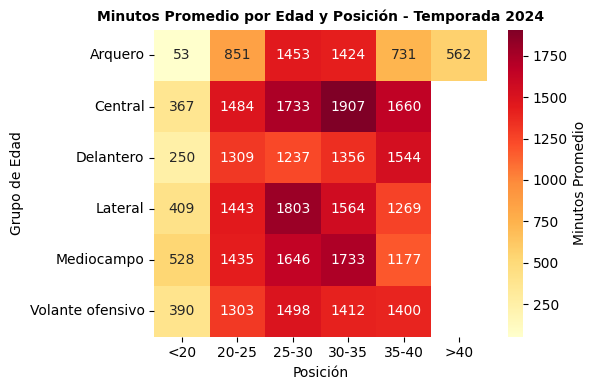

In [29]:
# Creo grupos de edad y elaboro un heatmap por posición de minutos jugados, tomando únicamente la última temporada 24/25
plt.figure(figsize=(6, 4))
df_jugadores_2024 = df_jugadores[df_jugadores['temporada'] == 2024].copy() # Create a copy
df_jugadores_2024['grupo_edad'] = pd.cut(df_jugadores_2024['player_age'], bins=[0, 20, 25, 30, 35, 40, 50],
                               labels=['<20', '20-25', '25-30','30-35', '35-40', '>40'])

heatmap_data = df_jugadores_2024.groupby(['player_pos','grupo_edad'], observed=False)['minutes_played'].mean().unstack()
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd',
            cbar_kws={'label': 'Minutos Promedio'})
plt.title('Minutos Promedio por Edad y Posición - Temporada 2024', fontsize=10, fontweight='bold')
plt.xlabel('Posición', fontsize=10)
plt.ylabel('Grupo de Edad', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

Es interesante ver cómo la única posición que cuenta con jugadores mayores a 40 años es la de arqueros, que no obstante ello, suman más minutos en la franja 25-35. Es un puesto en la cual se necesita experiencia, por lo cual es entendible el defasaje con las otras posiciones en las franjas de menor edad.

Otro gran aspecto a destacar, es como el grupo menor a 20 años refleja la menor cantidad de minutos jugados en todas sus posiciones, pero era el grupo más voluminoso según el análisis realizo al comienzo sobre la variable 'age'.

Por otra parte, la posición 'central'es la que evidencia el color mas intenso (mayor promedio de minutos jugados) en el grupo 30-35 años, valorando así la experiencia lograda por el jugador en los años previos.

##Lesiones

In [30]:
url_1 = "https://raw.githubusercontent.com/FranMoretti/TFI_Lesiones_Futbol/refs/heads/main/lesiones_scrapeadas.csv"
df_lesiones = pd.read_csv(url_1)
print(f"Filas: {df_lesiones.shape[0]}, Columnas: {df_lesiones.shape[1]}")
df_lesiones.head()

Filas: 46525, Columnas: 9


player_name  ... club_missed_games_for
0  James Trafford  ...                   NaN
1         Ederson  ...       Manchester City
2         Ederson  ...       Manchester City
3         Ederson  ...       Manchester City
4         Ederson  ...       Manchester City

[5 rows x 9 columns]

In [31]:
df_lesiones.tail()

player_name  ... club_missed_games_for
46520     Sidiki Chérif  ...            Angers SCO
46521     Sidiki Chérif  ...            Angers SCO
46522     Prosper Peter  ...                   NaN
46523  Willsem Boussaid  ...                   NaN
46524    Lanroy Machine  ...                   NaN

[5 rows x 9 columns]

Se observa que este dataset cuenta con 46.525 registros y 9 variables. Como mínimo hay 1 registro por jugador, dado que se tomaron las URL del primer set de datos y se trajo el dato de las lesiones, en que caso que haya tenido. Hay múltiples registros por jugador (uno por cada lesión), o como el primer caso que se visualizan nulos desde 'season_injured' en adelante, dado que no ha tenido lesiones. En caso que hayn tenido, las variables corresponden al tipo de lesión, equipo, temporada, fecha inicio, fecha fin, duración y partidos perdidos.

In [32]:
#Visualizo más información del df
df_lesiones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46525 entries, 0 to 46524
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   player_name            46525 non-null  object 
 1   player_url             46525 non-null  object 
 2   season_injured         44468 non-null  object 
 3   injury                 44468 non-null  object 
 4   injured_since          44465 non-null  object 
 5   injured_until          44180 non-null  object 
 6   duration               44468 non-null  object 
 7   games_missed           41854 non-null  float64
 8   club_missed_games_for  41854 non-null  object 
dtypes: float64(1), object(8)
memory usage: 3.2+ MB


Se observa que reconoce a 'df1' como un dataframe, como así también que cuenta con 8 variables tipo objeto y 1 numérica float64. No todas las variables sumarizan 46.525por lo que estamos en presencia de varios campos con *missing values* que corroboraré a continuación.

In [33]:
# Corroboro los missing values
df_lesiones.isnull().sum()

player_name                 0
player_url                  0
season_injured           2057
injury                   2057
injured_since            2060
injured_until            2345
duration                 2057
games_missed             4671
club_missed_games_for    4671
dtype: int64

Solo 2 variables cuentan con datos en todos sus registros (player_name, player_url).
Se observan ciertas congruencias en los missing values de diferentes variables, como por ejemplo:
1.   **season_injured/injury/duration:** todos poseen 2.057 casos. Es altamente probable que para ciertos registros falten las 3 variables a la vez. Lo cual chequearé más adelante.
2.   **injured_since:** posee 3 casos más que los campos previamente mencionados, por lo cual habría que ver si se comporta de la misma manera, y ver los casos extra en tal caso.
3.   **injured_until:** aquí estamos en presencia de 2.345, que podría guardar relación con los puntos anteriores, como así también deberse a los jugadores que al momento de extraer los datos se encontraban lesionados y aún no han retornado a la actividad, por lo cual es entendible que la cantidad de casos sea mayor.
4. **games_missed/club_missed_games_for:** poseen 4.671, siendo lógico pensar que si no hay datos de cuántos partidos se perdió por una lesión, no sepamos para qué equipo se encontraba jugando.

In [34]:
#Corroboro cuántos jugadores únicos tengo mi base
print(f"Jugadores únicos: {df_lesiones['player_url'].nunique()}")

Jugadores únicos: 7863


Coincide con lo que tenía en el set de datos de estadísticas por jugador/temporada/equipo.

In [35]:
# Analizaré el campo "Duration", que en los primeros registros figura el string "días"
termina_con_days = df_lesiones['duration'].str.endswith('days')
print(f"\n¿Todos terminan con 'days'?")
print(f"Sí: {termina_con_days.sum()}")


¿Todos terminan con 'days'?
Sí: 44468


In [36]:
# Procederé a eliminar el string "días", con el objetivo de facilitar luego el análisis de esa variable
df_lesiones['duration'] = (pd.to_numeric(df_lesiones['duration'].str.replace('days', '', regex=False).str.strip(),errors='coerce').astype('Int64'))

In [37]:
# Chequeo el resultado
df_lesiones['duration'].dtype

Int64Dtype()

In [38]:
# Transformo la otra variable ('games_missed') que era tipo float a int dado que se visualizó que todos los casos eran NaN o con decimal en cero
df_lesiones['games_missed'] = df_lesiones['games_missed'].astype('Int64')

In [39]:
df_lesiones.head(2)

player_name  ... club_missed_games_for
0  James Trafford  ...                   NaN
1         Ederson  ...       Manchester City

[2 rows x 9 columns]

In [40]:
# Filtro los 2.057 casos con 'season_injured' nulos para ver como se comportan el resto de las variables
lesiones_sin_temporada = df_lesiones[df_lesiones['season_injured'].isna()]
lesiones_sin_temporada.head(10)

player_name  ... club_missed_games_for
0        James Trafford  ...                   NaN
451       Harvey Davies  ...                   NaN
452     Jakub Ojrzynski  ...                   NaN
453         Liam Hughes  ...                   NaN
571      Billy Koumetio  ...                   NaN
572          Joel Matip  ...                   NaN
689   Leighton Clarkson  ...                   NaN
754           Jake Cain  ...                   NaN
920         Karlo Ziger  ...                   NaN
1246         Lewis Bate  ...                   NaN

[10 rows x 9 columns]

In [41]:
#Continúo con el análisis para confirmar si efectivamente todos las variables son nulos
lesiones_sin_temporada.isnull().sum()

player_name                 0
player_url                  0
season_injured           2057
injury                   2057
injured_since            2057
injured_until            2057
duration                 2057
games_missed             2057
club_missed_games_for    2057
dtype: int64

Efectivamente se confirma que existen 2.057 registros con prácticamente todos los datos de interés nulos, por lo cual procederé a eliminarlos para continuar con el análisis. Asimismo, eliminaré los 3 casos remanentes que quedarán en la variable 'injured_since' que en un inicio reflejaban 2.060 nulos.

In [42]:
# Se eliminan registros con 'season_injured' o 'injured_since' nulo
df_lesiones.dropna(subset=['season_injured'], inplace=True)
df_lesiones.dropna(subset=['injured_since'], inplace=True)

In [43]:
#Vuelvo a ver los nulos que quedan
df_lesiones.isnull().sum()

player_name                 0
player_url                  0
season_injured              0
injury                      0
injured_since               0
injured_until             287
duration                    0
games_missed             2611
club_missed_games_for    2611
dtype: int64

In [44]:
# Ahora visualizo algunos de los 287 casos con 'injured_until' nulo
df_lesiones[df_lesiones['injured_until'].isna()].head(5)

player_name  ... club_missed_games_for
14          Zack Steffen  ...       Colorado Rapids
185       Benjamin Mendy  ...             FC Zürich
542           Ozan Kabak  ...   TSG 1899 Hoffenheim
592         Marko Grujić  ...              FC Porto
1083  Jake Clarke-Salter  ...   Queens Park Rangers

[5 rows x 9 columns]

Si bien tienen injured_until nulo, tenemos el dato de la duración, por lo cual se puede utilizar para calcular el dato faltante.

In [45]:
# Calculo la 'duration' faltante, pero previamente le daré formato fecha a ambos campos, ya que actualmente figuran como object.
df_lesiones['injured_since'] = pd.to_datetime(df_lesiones['injured_since'])
df_lesiones['injured_until'] = pd.to_datetime(df_lesiones['injured_until'])
casos_a_completar = df_lesiones['injured_until'].isnull() & df_lesiones['injured_since'].notnull()
df_lesiones.loc[casos_a_completar, 'injured_until'] = (
    df_lesiones.loc[casos_a_completar, 'injured_since'] +
    pd.to_timedelta(df_lesiones.loc[casos_a_completar, 'duration'], unit='days'))

In [46]:
#Vuelvo a ver los nulos que quedan
df_lesiones.isnull().sum()

player_name                 0
player_url                  0
season_injured              0
injury                      0
injured_since               0
injured_until               0
duration                    0
games_missed             2611
club_missed_games_for    2611
dtype: int64

In [47]:
# Por último, filtro los 2.611 casos remanentes con 'games_missed' nulo. Analizo si efectivamente tiene lógica que no se hayan perdido partidos.
# Deberían ser todas lesiones breves y/o podría darse que no se perdió ningún partido porque no tiene club directamente
sin_partidos_perdidos = df_lesiones[df_lesiones['games_missed'].isna()]
hist_chart = alt.Chart(sin_partidos_perdidos).mark_bar(opacity=0.7, color='steelblue', stroke='black').encode(
    alt.X('duration:Q', bin=alt.Bin(maxbins=25), title='Duración (días)'),
    alt.Y('count():Q', title='Frecuencia'),
    tooltip=[alt.Tooltip('count():Q', title='Cantidad')]
).properties(
    width=400, height=250, title='Distribución de la Duración con games_missed nulo').configure_axis(
    labelFontSize=11, titleFontSize=12).configure_title(
    fontSize=14, anchor='middle')
hist_chart

alt.Chart(...)

In [48]:
# Visualizo cuantos casos tengo mayores a 60 días y con 'games_missed' nulo.
filtro = (df_lesiones['duration'] > 60) & (df_lesiones['games_missed'].isna())
df_filtrado = df_lesiones[filtro]
len(df_filtrado)

139

In [49]:
# Veo las principales medidas estadísticas de 'duration' cuando 'games_missed' es NaN
sin_partidos_perdidos['duration'].describe()

count       2611.0
mean     20.834929
std      93.791613
min            1.0
25%            4.0
50%            6.0
75%           13.0
max         3365.0
Name: duration, dtype: Float64

Si bien la mayor proporción guarda lógica con la idea previa de que ciertos registros de la variable 'games_missed' es nulo porque esa lesión no hizo perder ningún partido, también sorprende que pueda haber casos de más de 60 días (139 registros), que es el mayor lapso posible que un jugador de una liga top puede estar sin jugar por coincidir la lesión con el cierre de temporada y que a continuación tiene vacaciones sin jugar ningún torneo internacional. Asimismo, en el histograma se observa que existen múltiples casos de más de 200 días, lo cual no guarda relación, por lo cual sugiere errores en los datos o la incógnita respecto al criterio utilizado por Transfermarkt es que el jugador no se 'pierda' ningún partido porque tal vez directamente no tiene club.

Se destaca el caso máximo con 3.365 días (aprox. 9 años), una media de 20.8 días, con mediana de 6 días, indicando una distribución muy sesgada hacia la derecha. Asimismo, el 75% de los casos es menor o igual a13 días, por lo cual la mayoría son lesiones cortas.

Dado lo previamente descripto, creo una función que me sirva para eliminar los registros con 'games_missed' == NaN con enfoque estadístico, y luego se procederá a imputar los registros faltantes remanentes. Se utilizará el mínimo entre:

1. MAD (Median Absolute Deviation): Más robusto que el IQR para datos sesgados o con valores extremos, evita que los outliers distorsionen la medida de dispersión. Se calcula como la mediana de las distancias absolutas de cada dato respecto a la mediana, es decir, cuánto se separan los datos del valor central, pero usando la mediana para evitar el impacto de valores extremos. Se multiplica por 4 para que sea más conservador.
2. Percentil 99.5

In [50]:
# Calculo y visualizo los casos que se eliminarán
def identificar_outliers_estadisticos(df_lesiones):
    mediana_duracion = sin_partidos_perdidos['duration'].median()
    mad = np.median(np.abs(sin_partidos_perdidos['duration'] - mediana_duracion))
    umbral_estadistico = mediana_duracion + 4*mad
    umbral_percentil = sin_partidos_perdidos['duration'].quantile(0.995)
    umbral_final = min(umbral_estadistico, umbral_percentil)
    return umbral_final
umbral = identificar_outliers_estadisticos(sin_partidos_perdidos)
print(f"Umbral final para eliminar: {umbral:.1f} días")
outliers_extremos = sin_partidos_perdidos['duration'] > 365
outliers_hibridos = sin_partidos_perdidos['duration'] > umbral
games_missed_nan = sin_partidos_perdidos['games_missed'].isna()
a_eliminar = sin_partidos_perdidos[(games_missed_nan) & (outliers_extremos | outliers_hibridos)]
print("Casos que se eliminarán:")
a_eliminar[['duration', 'games_missed', 'injury', 'injured_since', 'injured_until']]

Umbral final para eliminar: 18.0 días
Casos que se eliminarán:


duration  games_missed              injury injured_since injured_until
21           23          <NA>             Fitness    2020-03-29    2020-04-20
204          36          <NA>         Knee injury    2017-06-14    2017-07-19
408          23          <NA>    Hamstring strain    2020-03-09    2020-03-31
490          57          <NA>  Torn muscle bundle    2023-06-16    2023-08-11
675          55          <NA>         Calf injury    2019-06-10    2019-08-03
...         ...           ...                 ...           ...           ...
45983        27          <NA>          Leg injury    2014-08-05    2014-08-31
46126        29          <NA>        ankle sprain    2025-01-11    2025-02-08
46147        52          <NA>      heart problems    2025-05-21    2025-07-12
46224        48          <NA>        Wrist injury    2025-05-21    2025-07-07
46442       141          <NA>         Knee injury    2023-04-28    2023-09-15

[414 rows x 5 columns]

In [51]:
# Elimino los 414 registros y actualizar df_lesiones
df_lesiones = df_lesiones.drop(a_eliminar.index).reset_index(drop=True)

In [52]:
# Para los casos que no se cortaron y permanecen con 'games_missed' == NaN se realizaré una imputación en base al campo 'duration'
# Primeramente calculo la correlación entre ambas variables y lo grafico
correlacion = df_lesiones['duration'].corr(df_lesiones['games_missed'])
scatter = alt.Chart(df_lesiones).mark_circle(opacity=0.7, stroke='white', strokeWidth=0.5).encode(
    x=alt.X('duration', title='Duración (días)'),
    y=alt.Y('games_missed', title='Partidos perdidos'),
    tooltip=['player_name:N','duration:Q','injury:N','games_missed:Q'])
regression = scatter.transform_regression('duration', 'games_missed', method='linear').mark_line(color='lightblue', strokeWidth=2)
chart = (scatter + regression).properties(
    width=500,
    height=300,
    title=f'Duración vs Partidos perdidos (r = {correlacion:.2f})')
chart

Output hidden; open in https://colab.research.google.com to view.

Predeciblemente existe una relación muy fuerte entre duración de lesión y partidos perdidos, siendo que el 88% de la variabilidad en partidos perdidos puede explicarse por la duración de la lesión. A partir de la inspección visual de este gráfico se identifica un registro donde tiene una duración de 1.877 días (5 años aprox.) y donde solo se habría perdido 51 partidos, lo cual no guarda relación con el resto de los casos y procederé a eliminar del dataset.

In [53]:
# Elimino el caso atípico en esta relación, y procedo a imputar los valores faltantes utilizando una regresión lineal dada la fuerte correlación de ambas variables
df_lesiones = df_lesiones[df_lesiones['duration'] != 1877]

def imputar_games_missed_por_regresion(df_lesiones):
    df = df_lesiones.copy()
    df_completos = df.dropna(subset=['games_missed'])
    X = df_completos[['duration']]
    y = df_completos['games_missed']
    modelo = LinearRegression()
    modelo.fit(X, y)
    faltantes = df['games_missed'].isna()
    predicciones = modelo.predict(df.loc[faltantes, ['duration']])
    df.loc[faltantes, 'games_missed'] = np.round(predicciones).astype(int)
    return df
df_lesiones = imputar_games_missed_por_regresion(df_lesiones)

In [54]:
# Vuelvo a visualizar mis datos faltantes
df_lesiones.isnull().sum()

player_name                 0
player_url                  0
season_injured              0
injury                      0
injured_since               0
injured_until               0
duration                    0
games_missed                0
club_missed_games_for    2197
dtype: int64

Ya solo queda la variable 'club_missed_games_for' la cual no será utilizada con posterioridad dado que refleja el nombre del equipo/selección para la cual se perdió partidos, siendo en ocasiones ambas situaciones a la vez, figurando un string con dos nombres separados por coma.

In [55]:
# Por ende elimino la variable 'club_missed_games_for' al no ser relevante
df_lesiones = df_lesiones.drop(columns=['club_missed_games_for'])

In [56]:
# Visualizo nuevamente la media, máximo, mínimo resultante en 'duration'
df_lesiones['duration'].describe()

count      44050.0
mean     35.922293
std      54.854185
min            1.0
25%            8.0
50%           18.0
75%           39.0
max         1093.0
Name: duration, dtype: Float64

Se observa una gran dispersión de datos, con una distribución claramente asimétrica hacia la derecha. Posee un mínimo es de 1 día, máximo de 1.093, con una media de 35.9 días. El valor máximo de 1.093 es considerablemente más alto que el percentil 75 (39), lo que sugiere la existencia de outliers significativos. Asimismo, se destaca que el 75% de las duraciones son de corta/intermedia duración (menores a 39 días).


In [57]:
# Relizo un histograma de la variable 'games_missed'
hist = alt.Chart(df_lesiones).mark_bar(opacity=0.7, stroke='black').encode(
    alt.X('games_missed:Q', bin=alt.Bin(maxbins=45), title='Partidos perdidos'),
    alt.Y('count()', title='Frecuencia'),
    tooltip=[alt.Tooltip('count()', title='Frecuencia')]).properties(
    width=500,
    height=250,
    title='Histograma de games_missed')
hist.configure_axis(grid=True, gridOpacity=0.3)

Output hidden; open in https://colab.research.google.com to view.

In [58]:
df_lesiones['games_missed'].describe()

count     44050.0
mean     5.610783
std      7.915221
min           1.0
25%           1.0
50%           3.0
75%           6.0
max         145.0
Name: games_missed, dtype: Float64

Al igual que la variable 'Duration' se observa una gran dispersión de datos, con una distribución claramente asimétrica hacia la derecha. Posee un mínimo de 1 juego perdido, máximo de 145, con una media de 5.6 juegos perdidos. El valor máximo de 145 es considerablemente más alto que el percentil 75 (6), lo que sugiere la existencia de outliers significativos. Además, se destaca que el 75% de los datos están por debajo de 6 juegos perdidos, indicando que la mayoría de los jugadores pierden relativamente pocos partidos, que no obstante ello, dependiendo en qué momento de la temporada es, puede ser crucial para los objetivos del equipo.

In [59]:
df_lesiones['player_url'].nunique()
# Finalmente quedaron 5.779 jugadores únicos en este dataset

5779

In [60]:
# ¿Cuáles son las lesiones más frecuentes?
duckdb.register('df_lesiones', df_lesiones)
consulta = """
SELECT
    injury AS tipo_lesion,
    COUNT(*) AS Cantidad,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM df_lesiones), 2) AS "Porcentaje (%)"
FROM df_lesiones
GROUP BY injury
ORDER BY Cantidad DESC
LIMIT 20
"""
tabla_lesiones = duckdb.sql(consulta).df()
tabla_lesiones

tipo_lesion  Cantidad  Porcentaje (%)
0           unknown injury      3824            8.68
1         Hamstring injury      2791            6.34
2            Muscle injury      2355            5.35
3        muscular problems      2100            4.77
4              Knee injury      1689            3.83
5             Ankle injury      1628            3.70
6             Corona virus      1470            3.34
7                    Knock      1306            2.96
8                      Ill      1293            2.94
9           Thigh problems      1027            2.33
10                 Fitness      1015            2.30
11           Knee problems       933            2.12
12             Calf injury       841            1.91
13           Adductor pain       762            1.73
14       Torn muscle fiber       713            1.62
15  Cruciate ligament tear       675            1.53
16         Shoulder injury       639            1.45
17             minor knock       567            1.29
18            Groin injury       547            1.24
19             Foot injury       523            1.19

In [61]:
#Cuántos tipos de lesiones tengo
print(df_lesiones['injury'].nunique())

325


Con estas últimas 2 celdas surgen 2 problemas importantes a tratar:

1.   El tipo de lesión más comun es 'desconocida' (unknown injury)
2.   Gran variedad de tipos de lesión, por lo cual tendré que elaborar una clasificación más homogénea.

In [62]:
#Procederé a hacer una clasificación según terminología médica
def clasificar_lesion(injury):
    injury = injury.lower()
    if any(p in injury for p in ['hamstring','Contracture', 'muscle', 'muscular', 'calf', 'thigh', 'adductor', 'groin', 'dead leg','strain','Lumbago','fatigue', 'back problems', 'pubalgia', 'overuse']):
        return 'Muscular/Sobrecarga'
    if any(p in injury for p in ['fracture', 'broken', 'bone', 'stress fracture', 'crack']):
        return 'Osea'
    if any(p in injury for p in ['sprain', 'ligament', 'meniscus', 'cruciate', 'knee injury', 'ankle sprain']):
        return 'Articular/Ligamentosa'
    if any(p in injury for p in ['tendon', 'tendinitis', 'tenosynovitis']):
        return 'Tendinosa'
    if any(p in injury for p in ['knock', 'injury', 'problems','bruise','bruised','concussion','edema','surgery']):
        return 'Traumatica inespecifica'
    if any(p in injury for p in ['rest', 'fitness']):
        return 'No lesion/Manejo fisico'
    if any(p in injury for p in ['corona', 'virus', 'ill', 'flu']):
        return 'Otros'
    return 'Otros'

df_lesiones['categoria_lesion'] = df_lesiones['injury'].apply(clasificar_lesion)
df_lesiones['categoria_lesion'].value_counts().reset_index()

categoria_lesion  count
0      Muscular/Sobrecarga  16089
1  Traumatica inespecifica  14018
2                    Otros   5652
3    Articular/Ligamentosa   4677
4                     Osea   1481
5  No lesion/Manejo fisico   1448
6                Tendinosa    685

Las lesiones fueron categorizadas agrupando términos clave según el tipo de estructura afectada:
**Muscular/Sobrecarga** incluye tanto lesiones musculares (como “hamstring”, “strain”, “contracture”) como condiciones derivadas del sobreuso o desgaste físico (“lumbago”, “fatigue”, “overuse”).
**Ósea** reúne fracturas o daños en huesos mediante términos como “fracture”, “broken” o “crack”.
**Articular/Ligamentosa** abarca lesiones en articulaciones o ligamentos, como “sprain”, “meniscus” o “cruciate”.
**Tendinosa** identifica lesiones en tendones, como “tendinitis” o “tenosynovitis”.
**Traumática inespecífica** agrupa golpes, contusiones o lesiones no específicas, incluyendo “knock”, “injury”, “bruise” o “surgery”.
**No lesión/Manejo físico** se asigna a ausencias por decisión técnica o falta de forma (“rest”, “fitness”), mientras que **Otros** agrupa enfermedades o condiciones médicas no traumáticas como “virus” o “flu”.

In [63]:
# Lo grafico
categoria_counts = df_lesiones['categoria_lesion'].value_counts()
total = categoria_counts.sum()
porcentajes = (categoria_counts / total * 100).round(1).reset_index()
porcentajes.columns = ['categoria_lesion', 'porcentaje']
porcentajes['cantidad'] = categoria_counts.values

bars = alt.Chart(porcentajes).mark_bar(color='cornflowerblue', stroke='black').encode(
    y=alt.Y('categoria_lesion:N', sort='-x', title='Categoría de lesión'),
    x=alt.X('porcentaje:Q', title='Porcentaje (%)'),
    tooltip=[alt.Tooltip('cantidad:Q', title='Cantidad de lesiones', format=',.0f')])
text = alt.Chart(porcentajes).mark_text(align='left', baseline='middle', dx=3, fontWeight='bold').encode(
    y=alt.Y('categoria_lesion:N', sort='-x'),
    x='porcentaje:Q',
    text=alt.Text('porcentaje:Q', format='.1f'))
grafico = (bars + text).properties(width=500, height=250, title='Distribución porcentual por tipo de lesión').configure_axis(grid=True, gridOpacity=0.3)
grafico

alt.LayerChart(...)

Las lesiones de tipo muscular/sobrecarga son las principales, representando el 36.5% del total, seguido por las traumáticas inespecíficas que alcanzaron el 31.8%. A continuación, la categoría 'Otros' que continuación profundizaré con el 12.8%, 'Articular/Ligamentosa' con 10.6% y la 'Osea' solo el 3.4%.

In [64]:
# Visualizo las pricipales afecciones que quedaron catalogadas como 'Otros'
otros_df1 = df_lesiones[df_lesiones['categoria_lesion'] == 'Otros']
otros_df1['injury'].value_counts().head(5).reset_index()

injury  count
0  Corona virus   1470
1           Ill   1293
2     influenza    373
3           flu    309
4    Quarantine    263

Principalmente corresponden a coronavirus, gripe, fiebre, malestar general, que entre los primeros 5 ya cubren el 65% del total de 'Otros'.

In [65]:
# Paso a graficar la evolución de la sumatoria total de días de lesión y cantidad de lesiones por temporada
# Descarto los casos 'categoria_lesion' == 'otros' y 'no lesión/manejo físico' para no contaminarlo con casos que no son lesiones en sí mismas
# No se grafican temporadas anteriores dado que solo extraje las lesiones de aquellos jugadores de las 5 ligas top de europa para el lapso 2020/2025
df_filtrado = df_lesiones[
    (~df_lesiones['categoria_lesion'].isin(['Otros', 'No lesion/Manejo fisico'])) &
    (df_lesiones['season_injured'].isin(['20/21', '21/22', '22/23', '23/24', '24/25']))]

df_suma_dias = df_filtrado.groupby('season_injured', as_index=False)['duration'].sum()
df_cant_lesione = df_filtrado.groupby('season_injured', as_index=False).size().rename(columns={'size': 'cantidad'})

linea_suma_dias = alt.Chart(df_suma_dias).mark_line(point=True, color='teal', strokeWidth=2.5).encode(
    x=alt.X('season_injured:N', title='Temporada', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('duration:Q', title='Días de lesión', scale=alt.Scale(zero=False)),
    tooltip=['season_injured', 'duration']).properties(
    width=500,
    height=250,
    title='Evolución de los días de lesión acumulados por temporada')

linea_cant_lesiones = alt.Chart(df_cant_lesione).mark_line(point=True, color='teal', strokeWidth=2.5).encode(
    x=alt.X('season_injured:N', title='Temporada', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('cantidad:Q', title='Cantidad de lesiones', scale=alt.Scale(zero=False)),
    tooltip=['season_injured', 'cantidad']).properties(
    width=500,
    height=250,
    title='Evolución de la cantidad de lesiones por temporada')

(linea_suma_dias | linea_cant_lesiones).configure_axis(grid=True, gridOpacity=0.3).configure_point(size=60).configure_title(fontSize=14, anchor='middle')

alt.HConcatChart(...)

En el gráfico de la izquierda se observa una clara tendencia alcista en la sumatoria de días de lesión acumulados desde 20/21 en adelante, habiendo tocado un pico en la temporada pasada (23/24) y con una leve disminución en la que acaba de finalizar (24/25). Asimismo, en el gráfico de la derecha se visualiza un aumento exponencial en la cantidad de lesiones bajo el período analizado. Claramente en los últimos años hay más lesiones y que los aleja de las canchas más tiempo. Además, teniendo en cuenta lo analizado en el set de datos de jugadores donde la cantidad promedio de jugadores por equipo en el mismo lapso creció, pero solo en promedio 1 o 2 jugadore por liga, no llega a explicar el exponencial crecimiento de las lesiones, que se podría atribuir entonces a la mayor cantidad de minutos jugados y al menor descanso entre partidos.

In [66]:
# Esto me hace pensar en graficar ahora solo 'No lesion/Manejo fisico', que si bien no es una lesión en si misma, evidenciaría cómo los cuerpos técnicos priorizan el descanso y rotación para evitar lesiones
temporadas_validas = ['20/21', '21/22', '22/23', '23/24', '24/25']
df_filtrado = df_lesiones[
    (df_lesiones['season_injured'].isin(temporadas_validas)) &
    (df_lesiones['categoria_lesion'] == 'No lesion/Manejo fisico')]

df_suma_dias = df_filtrado.groupby('season_injured', as_index=False)['duration'].sum()
df_cant_lesione = df_filtrado.groupby('season_injured', as_index=False).size().rename(columns={'size': 'cantidad'})

linea_suma_dias = alt.Chart(df_suma_dias).mark_line(point=True, color='teal', strokeWidth=2.5).encode(
    x=alt.X('season_injured:N', title='Temporada', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('duration:Q', title='Días de lesión', scale=alt.Scale(zero=False)),
    tooltip=['season_injured', 'duration']).properties(
    width=500,
    height=250,
    title='Evolución de los días de lesión acumulados por temporada (No lesion/Manejo fisico)')

linea_cant_lesiones = alt.Chart(df_cant_lesione).mark_line(point=True, color='teal', strokeWidth=2.5).encode(
    x=alt.X('season_injured:N', title='Temporada', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('cantidad:Q', title='Cantidad de lesiones', scale=alt.Scale(zero=False)),
    tooltip=['season_injured', 'cantidad']).properties(
    width=500,
    height=250,
    title='Evolución de la cantidad de lesiones por temporada (No lesion/Manejo fisico)')
(linea_suma_dias | linea_cant_lesiones).configure_axis(grid=True, gridOpacity=0.3).configure_point(size=60).configure_title(fontSize=14, anchor='middle')

alt.HConcatChart(...)

Es interesante ver como entre las temporadas 20/21 y 22/23 se oberva un crecimiento marginal, luego en las últimas 2 temporadas (23/24 y 24/25) las curvas se incrementan notablemente, lo cual podría evidenciar cómo los DT y cuerpos técnicos comenzaron a visibilizar esta problemática y a actuar en consecuencia.

In [67]:
# Análisis de Duration y la categoría de la lesión
# Filtro las lesiones menores a 180 días porque de lo contrario con los outliers se vuelve dificil de interpretar
df_filtrado = df_lesiones[df_lesiones['duration'] < 180].copy()
boxplot = alt.Chart(df_filtrado).mark_boxplot(outliers=True,extent='min-max', size=35).encode(
    x=alt.X('duration:Q', title='Duración (días)'),
    y=alt.Y('categoria_lesion:N', title='Categoría de lesión', sort='-x'),
    color=alt.Color('categoria_lesion:N', legend=None)).properties(
    width=500,
    height=300,
    title='Duración de lesiones por categoría').configure_axis(
    grid=True,
    gridOpacity=0.3)
boxplot

Output hidden; open in https://colab.research.google.com to view.

Como uno podría inferir, se observa que las lesiones óseas presentan las duraciones más largas y consistentes, con una mediana alrededor de 43 días y casos que se extienden hasta 177 días, siendo claramente las más problemáticas. Asimismo, las lesiones tendinosas también muestran gran variabilidad, con un muchos casos entre 12 y 71, seguido de las articulares/ligamentosas que concentran entre 18/63 días y destacando con la 2da mediana más elevada (37). Estas tres categorías evidencian los rangos intercuartílicos más amplios.

A continuación las lesiones musculares/sobrecarga tienen la mayoría de casos entre 10/34 días, con una media de 19 días. Mientras que las traumáticas inespecíficas poseen un comportamiento bastante similar a las musculares, con una mediana levemente inferior (15).

Por último, las catalogadas como "no lesión/manejo físico" y "otros" muestran las duraciones más cortas del gráfico, lo cual guarda relación con el análisis realizado previamente respecto a qué tipo de lesiones engloba cada una.

Se podría decir que esta distribución es consistente con el conocimiento médico deportivo, ya que el hueso y los tendones requieren más tiempo para sanar completamente que el tejido muscular.

In [68]:
df_lesiones['lesion'] = np.where(df_lesiones['categoria_lesion'].isin(['No lesion/Manejo fisico', 'Otros']), 0, 1)
df_lesiones.head(1)

player_name  ... lesion
0     Ederson  ...      1

[1 rows x 10 columns]

La categoría 'No lesión/Manejo físico' trae aparejada una nueva incógnita: ¿corresponde clasificar como lesión algo que no es lesión en si misma? Lo mismo para la categoría 'Otros' que entre sus principales componentes se encuentran malestares relacionados con virus respiratorios. Dado ello incorporo un campo que haga esta distinción para el análisis. Además, se pudo obsevar que ambas categorías no marginan a los jugadores gran cantidad de días/partidos, por lo cual incluirlas en nuevas variables que totalicen cantidad de lesiones podría ser perjudicial para el modelo.

# Creación de nuevas variables, merge y dataframe final para modelar

In [69]:
# Creo registros únicos por jugador tomando la variable 'player_url', sumando el total de minutos jugados y apariciones por temporada + total, como así también me traigo (y calculo en algunos casos) la edad del jugador para la temporada 23/24
# No totalizo por 'in_squad' ya que las otras variables son más relevantes, ni tampoco los goles
# Transformo el formato 'temporada' 2020 en 20/21 para una correcta representación y que quede alineada con df_lesiones que maneja el mismo criterio
df_jugadores['season_str'] = df_jugadores['temporada'].astype(str).str[-2:] + '/' + (df_jugadores['temporada'] + 1).astype(str).str[-2:]

# Totalizar minutos jugados por jugador y temporada
minutos_totales = df_jugadores.groupby(['player_url', 'season_str'], as_index=False)['minutes_played'].sum()
minutos_pivot = minutos_totales.pivot(index='player_url', columns='season_str', values='minutes_played').fillna(0)
minutos_pivot.columns = [f'minutes_played_{c.replace("/", "_")}' for c in minutos_pivot.columns]
df_jugadores_ordenado = df_jugadores.sort_values(['player_url', 'temporada', 'minutes_played'], ascending=[True, False, False])
info_basica = df_jugadores_ordenado.drop_duplicates('player_url', keep='first')[['player_url', 'player_name', 'player_pos', 'liga']]

# Edad temporada 23/24, si está me quedo con esa y sino la calculo en base a la temporada que sí tengo
edad_23_24 = df_jugadores[df_jugadores['temporada'] == 2023][['player_url', 'player_age']]
edad_23_24 = edad_23_24.rename(columns={'player_age': 'player_age_23_24'})
ultima_edad = df_jugadores.sort_values('temporada').drop_duplicates('player_url', keep='last')[['player_url', 'temporada', 'player_age']]
ultima_edad['años_a_sumar'] = 2023 - ultima_edad['temporada']
ultima_edad['player_age_23_24_estimado'] = ultima_edad['player_age'] + ultima_edad['años_a_sumar']
ultima_edad = ultima_edad[['player_url', 'player_age_23_24_estimado']]
edad_completa = edad_23_24.merge(ultima_edad, on='player_url', how='outer')
edad_completa['player_age_23_24'] = edad_completa['player_age_23_24'].fillna(edad_completa['player_age_23_24_estimado'])
edad_completa = edad_completa[['player_url', 'player_age_23_24']]
edad_completa = edad_completa.drop_duplicates('player_url', keep='first')

# Merge final
df_jugadores_final = info_basica.merge(minutos_pivot, on='player_url', how='left')
df_jugadores_final = df_jugadores_final.merge(edad_completa, on='player_url', how='left')
df_jugadores_final.head()

player_url  ... player_age_23_24
0  https://www.transfermarkt.com/aaron-anselmino/...  ...             18.0
1  https://www.transfermarkt.com/aaron-ciammaglic...  ...             18.0
2  https://www.transfermarkt.com/aaron-connolly/p...  ...             23.0
3  https://www.transfermarkt.com/aaron-cresswell/...  ...             33.0
4  https://www.transfermarkt.com/aaron-donnelly/p...  ...             20.0

[5 rows x 10 columns]

In [70]:
# Defino las temporadas recientes, en las cuales voy a totalizar la cantidad de lesiones y sumatoria de días lesionado. Esto se debe a que tengo lesiones de un jugador desde el año 2010 tal vez, y no quiero que tengan tanta relevancia en mi modelo.
temporadas_modelo = ['20/21', '21/22', '22/23', '23/24', '24/25']

# Lesiones desde 20/21 agrupando por jugador y temporada
df_recientes = df_lesiones[
    (df_lesiones['lesion'] == 1) &
    (df_lesiones['season_injured'].isin(temporadas_modelo))].copy()
df_resumen = df_recientes.groupby(['player_url', 'season_injured']).agg(
    num_lesiones=('injury', 'count'),
    dias_lesionado=('duration', 'sum')).reset_index()
df_lesiones_pivot = df_resumen.pivot(index='player_url', columns='season_injured')
df_lesiones_pivot.columns = [f'{metric}_{season.replace("/", "_")}' for metric, season in df_lesiones_pivot.columns]
df_lesiones_pivot = df_lesiones_pivot.reset_index().fillna(0)

# Creo además mi variable target que sera == 1 si tuvo al menos una lesión 'real', y == 0 si no tuvo lesiones 'reales'.
df_lesiones_pivot['lesionado_24_25'] = (df_lesiones_pivot.get('num_lesiones_24_25', 0) > 0).astype(int)

# Acumulo lesiones previsa a temporada 20/21
df_anteriores = df_lesiones[
    (df_lesiones['lesion'] == 1) &
    (~df_lesiones['season_injured'].isin(temporadas_modelo))]
df_anteriores_agg = df_anteriores.groupby('player_url').agg(
    lesiones_antes_20_21=('injury', 'count'),
    dias_antes_20_21=('duration', 'sum')).reset_index()

# Merge final
df_lesiones_final = df_lesiones_pivot.merge(df_anteriores_agg, on='player_url', how='left').fillna(0)
df_lesiones_final.head()

player_url  ...  dias_antes_20_21
0  https://www.transfermarkt.com/aaron-anselmino/...  ...                 0
1  https://www.transfermarkt.com/aaron-ciammaglic...  ...                 0
2  https://www.transfermarkt.com/aaron-connolly/p...  ...                92
3  https://www.transfermarkt.com/aaron-cresswell/...  ...               230
4  https://www.transfermarkt.com/aaron-hickey/pro...  ...                40

[5 rows x 14 columns]

In [71]:
# Unifico ambos dataframes
df_completo = df_jugadores_final.merge(df_lesiones_final, on='player_url', how='left')
print(f"Filas: {df_completo.shape[0]}, Columnas: {df_completo.shape[1]}")
df_completo = df_completo.fillna(0)
df_completo.head(1)

Filas: 7863, Columnas: 23


player_url  ... dias_antes_20_21
0  https://www.transfermarkt.com/aaron-anselmino/...  ...                0

[1 rows x 23 columns]

Momentáneamente tengo un dataframe con 7.863 jugadores (los mismos que tenía inicialmente) y 23 variables. No obstante, ahora que tengo ambas bases unidas, podré crear nuevas variables que combinen minutos jugados con lesiones por ejemplo, entre otras. Como así también, profundizar en nuevos análisis y gráficos comparativos.

In [72]:
# Nuevas variables
# Tendencia reciente de lesiones (previo al target)
df_completo['tendencia_lesiones'] = df_completo['num_lesiones_23_24'] - df_completo['num_lesiones_22_23']

# Promedio anual de lesiones en últimas 3 temporadas
df_completo['prom_lesiones_ult_3'] = df_completo[
    ['num_lesiones_20_21', 'num_lesiones_21_22', 'num_lesiones_22_23']].mean(axis=1)

# Cuánto días permanece fuera de cancha por cada minuto jugado: días lesionado / minutos jugados. Se la podría denominar como propensión a lesionarse.
for temp in ['20_21', '21_22', '22_23', '23_24', '24_25']:
    df_completo[f'propension_lesion{temp}'] = df_completo[f'dias_lesionado_{temp}'] / (df_completo[f'minutes_played_{temp}'] + 1)

# Acumulado de carga total de minutos jugados en las últimas temporadas (previa al target)
df_completo['carga_total_minutos'] = df_completo[
    ['minutes_played_20_21', 'minutes_played_21_22', 'minutes_played_22_23', 'minutes_played_23_24']].sum(axis=1)

# Acumulado de lesiones previas hasta 23/24
df_completo['total_lesiones_previas'] = df_completo[
    ['num_lesiones_20_21', 'num_lesiones_21_22', 'num_lesiones_22_23', 'num_lesiones_23_24']].sum(axis=1)

# Edad transformada (cuadrado) -->  transformación polinómica para capturar relaciones no lineales (permite que incluso un modelo lineal o de árbol pueda detectar patrones no lineales en cómo la edad afecta el riesgo de lesión)
df_completo['player_age_23_24_cuadrado'] = df_completo['player_age_23_24'] ** 2

In [73]:
# Grafico la cantidad de lesiones por liga en la última temporada
datos_agrupados = df_completo.groupby('liga')['num_lesiones_24_25'].sum().reset_index()
grafico = alt.Chart(datos_agrupados).mark_bar().encode(
    x=alt.X('num_lesiones_24_25:Q', title='Cantidad'),
    y=alt.Y('liga:N', title='Liga', sort='-x'),
    tooltip=alt.Tooltip('num_lesiones_24_25:Q')
).properties(
    width=400,
    height=200,
    title='Total de Lesiones por Liga Temp. 24/25'
)
grafico.show()

alt.Chart(...)

Los jugadores de la Serie A es la que evidenció una mayor cantidad de lesiones en la última temporada, con una marcada diferencia por sobre la Bundesliga y la Premier League, que se ubicaron en 2do y 3er lugar respectivamente. A conitnuación, se encuentra la Ligue 1 y por último La Liga (España) con menos de la mitad de lesiones que la liga italiana (Serie A).

In [74]:
# Verifico si todas las ligas poseen la misma distribución en cuanto al tipo de lesión 'real'
# Filtramos por temporada 24/25 y solo lesiones reales
df_lesiones_2425 = df_lesiones[
    (df_lesiones['season_injured'] == '24/25') & (df_lesiones['lesion'] == 1)
]

df_merged = pd.merge(df_lesiones_2425, df_completo[['player_url', 'liga']], on='player_url', how='left')

df_grafico = df_merged.groupby(['liga', 'categoria_lesion']).size().reset_index(name='cantidad_lesiones')
total_por_liga = df_grafico.groupby('liga')['cantidad_lesiones'].sum().reset_index()
total_por_liga.columns = ['liga', 'total_liga']
df_grafico = df_grafico.merge(total_por_liga, on='liga')
df_grafico['porcentaje'] = (df_grafico['cantidad_lesiones'] / df_grafico['total_liga']) * 100


grafico = alt.Chart(df_grafico).mark_bar().encode(
    x=alt.X('porcentaje:Q', title='Porcentaje (%)', scale=alt.Scale(domain=[0, 100])),
    y=alt.Y('liga:N', title='Liga'),
    color=alt.Color('categoria_lesion:N', title='Tipo de Lesión'),
    tooltip=[
        alt.Tooltip('categoria_lesion:N', title='Tipo de Lesión'),
        alt.Tooltip('cantidad_lesiones:Q', title='Cantidad'),
        alt.Tooltip('porcentaje:Q', title='Porcentaje (%)', format='.1f')
    ]).properties(
    width=450,
    height=250,
    title='Lesiones por Tipo y Liga - Temporada 24/25')
grafico.show()

alt.Chart(...)

A priori se puede observar que el comportamiento es bastante homogéneo, pero con algunas particularidades a destacar:
1.   La Liga (España) y Ligue 1 (Francia), poseen más proporción (14/15%)  de lesiones tipo Articular/Ligamentosa que las otras ligas (8/11%).
2.   Las lesiones musculares/sobrecarga, se extienden desde el 42% en la liga inglessa 50% en la española.
3. La Liga (España) es quien posee la menor proporción de lesiones de tipo traumáticas inespecíficas (30%), mientras que la Premier League es la mayor (44%).
4. Las lesiones de tipo tendinosas en todas las ligas se encuentra entre el 1.9% y 2.4%, mientras que la de tipo ósea van desde el 2.4% (Ligue 1) hasta el 4.5% en La Liga.



In [75]:
# Y ahora, como varía el tipo de lesiones según la posición en el campo
df_lesiones_2425 = df_lesiones[
    (df_lesiones['season_injured'] == '24/25') & (df_lesiones['lesion'] == 1)
]

df_merged_pos = pd.merge(df_lesiones_2425, df_completo[['player_url', 'player_pos']], on='player_url', how='left')

df_grafico_pos = df_merged_pos.groupby(['player_pos', 'categoria_lesion']).size().reset_index(name='cantidad_lesiones')
total_por_posicion = df_grafico_pos.groupby('player_pos')['cantidad_lesiones'].sum().reset_index()
total_por_posicion.columns = ['player_pos', 'total_posicion']
df_grafico_pos = df_grafico_pos.merge(total_por_posicion, on='player_pos')
df_grafico_pos['porcentaje'] = (df_grafico_pos['cantidad_lesiones'] / df_grafico_pos['total_posicion']) * 100

grafico = alt.Chart(df_grafico_pos).mark_bar().encode(
    x=alt.X('porcentaje:Q', title='Porcentaje (%)', scale=alt.Scale(domain=[0, 100])),
    y=alt.Y('player_pos:N', title='Posición'),
    color=alt.Color('categoria_lesion:N', title='Tipo de Lesión'),
    tooltip=[
        alt.Tooltip('categoria_lesion:N', title='Tipo de Lesión'),
        alt.Tooltip('cantidad_lesiones:Q', title='Cantidad'),
        alt.Tooltip('porcentaje:Q', title='Porcentaje (%)', format='.1f')
    ]).properties(
    width=450,
    height=250,
    title='Lesiones por Tipo y Posición - Temporada 24/25')
grafico.show()

alt.Chart(...)

Se obseva un comportamiento bastante homogéneo en todas las posiciones, excepto por la del Arquero, la cual posee una mayor proporción de lesiones traumáticas inespecíficas (52.5%) y óseas (8.7%), en detrimento de las musculares/sobrecarga donde asciende a 26.6%, mientras que las restantes posiciones andan en el orden del 36% y 3% respectivamente.

In [76]:
# Comparo la cantidad de días de lesión por posición (Temp. 24/25)
datos_filtrados = df_completo[(df_completo['dias_lesionado_24_25'].notna()) & (df_completo['dias_lesionado_24_25'] > 0)]
grafico = alt.Chart(datos_filtrados).mark_boxplot(
    outliers=True,
    size=30).encode(
    y=alt.Y('player_pos:N', title='Posición', sort='-x'),
    x=alt.X('dias_lesionado_24_25:Q', title='Cant. Días', scale=alt.Scale(zero=False)),
    tooltip=[alt.Tooltip('player_name:N', title='Nombre'), alt.Tooltip('dias_lesionado_24_25:Q', title='Cant. Días')]).properties(
    width=450,
    height=250,
    title='Distribución de Días Lesionado por Posición - Temp. 24/25')
grafico.show()

Output hidden; open in https://colab.research.google.com to view.

A priori, se visualiza que las medianas son bastante similares en todas las posiciones, manejándose en el rango de los 42.5 y 49 días. El rango intercuartílico de los centrales se destaca como el más amplio de todos.

Asimismo, se observa un caso de 466 días de lesión en la última temporada, lo cual llama la atención, por lo cual procederé a inspeccionarlo.

In [77]:
df_lesiones[df_lesiones['player_name'] == 'Chadi Riad']

player_name  ... lesion
10121  Chadi Riad  ...      1
10122  Chadi Riad  ...      1

[2 rows x 10 columns]

Pareciera esta OK, dado que el jugador sufrió una cirugía de rodilla comenzando la temporada (ago-24) y luego del receso de invierno europeo sufrió una lesión en el ligamento cruzado, lo cual lo marginó de las canchas aproximadamente un 1 año más, por lo cual la sumatoria de ambas lesiones le da 466 días.

In [78]:
# Genero mi df final donde seteo player_url com index, elimino las variables de 24/25 (excepto target), creo dummys para la posición del jugador, y elimino todas las demás variables que no utilizaré para entrenar el modelo
df_modelo = df_completo.copy()
df_modelo.set_index('player_url', inplace=True)
cols_a_eliminar_24_25 = [col for col in df_modelo.columns
                         if '24_25' in col and col != 'lesionado_24_25']
otras_cols_a_eliminar = ['player_name', 'liga']
df_modelo = pd.get_dummies(df_modelo, columns=['player_pos'], prefix='pos', drop_first=True)
bool_cols = df_modelo.select_dtypes(include='bool').columns
df_modelo[bool_cols] = df_modelo[bool_cols].astype(int)
df_modelo.drop(columns=cols_a_eliminar_24_25 + otras_cols_a_eliminar, inplace=True)
print(f"Shape final: {df_modelo.shape}")
target = df_modelo.pop('lesionado_24_25').astype(int)
df_modelo['lesionado_24_25'] = target
df_modelo.head().reset_index()

Shape final: (7863, 30)


player_url  ...  lesionado_24_25
0  https://www.transfermarkt.com/aaron-anselmino/...  ...                1
1  https://www.transfermarkt.com/aaron-ciammaglic...  ...                1
2  https://www.transfermarkt.com/aaron-connolly/p...  ...                0
3  https://www.transfermarkt.com/aaron-cresswell/...  ...                1
4  https://www.transfermarkt.com/aaron-donnelly/p...  ...                0

[5 rows x 31 columns]

# Modelo final 1 (Clasificación: Variable target 'lesionado_24_25' 0/1)

In [79]:
# Verificar si la variable df_modelo existe en memoria y sino lo levanta de github
try:
    df_modelo
except NameError:
    import pandas as pd
    df_modelo = pd.read_csv('https://raw.githubusercontent.com/FranMoretti/TFI_Lesiones_Futbol/refs/heads/main/df_modelo.csv')
    df_modelo.set_index('player_url', inplace=True)
    print("df_modelo creado desde el enlace.")
else:
    print("df_modelo ya existe en memoria.")

df_modelo ya existe en memoria.


In [80]:
# ¿Cuántos registros con variable target tengo ==1 e ==0?
duckdb.query("""
    SELECT
        lesionado_24_25,
        COUNT(*) AS cantidad
    FROM df_modelo
    GROUP BY lesionado_24_25
""").df()

lesionado_24_25  cantidad
0                0      5047
1                1      2816

Se observa un leve desbalance (64% vs 36%) que podría afectar el modelo, por lo cual tendré en cuenta ello para ajustar ciertos parámetros.

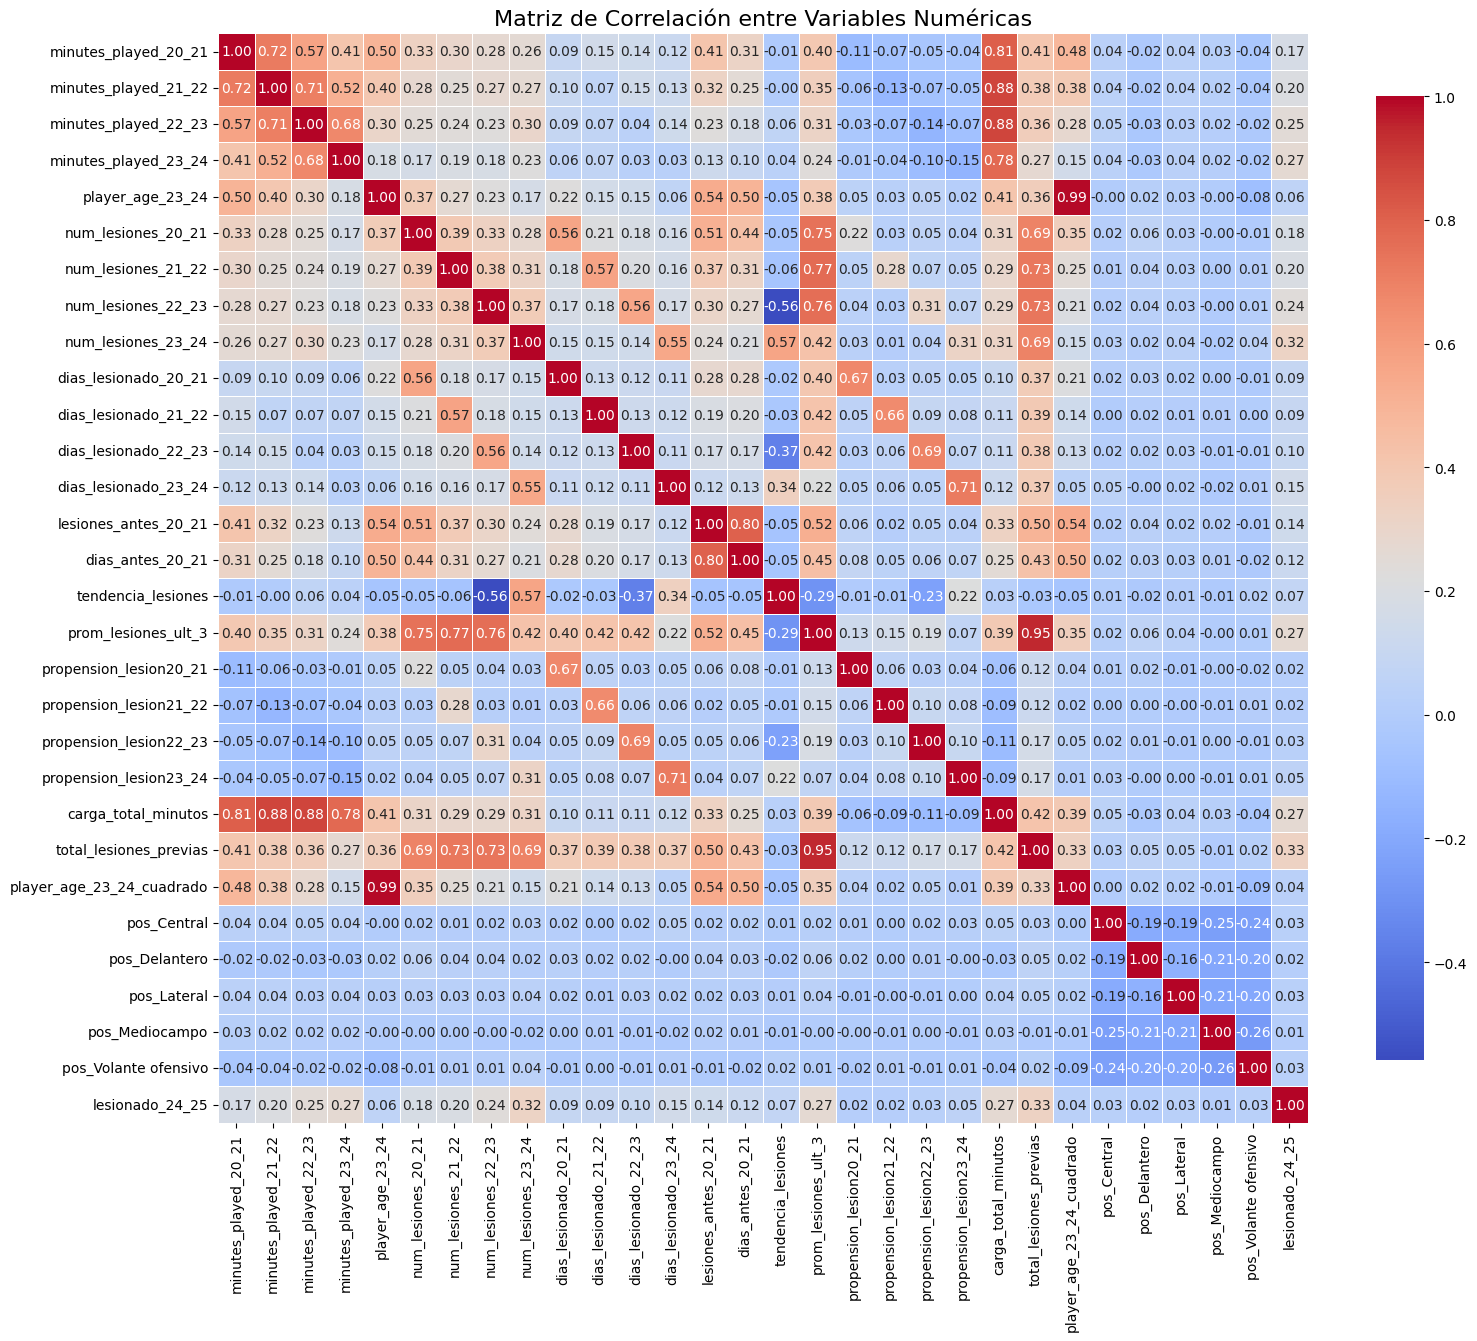

In [81]:
# Heatmap para ver la correlacion entre todas las variables, pero específicamente las de la variable target lesionado_24_25
variables_numericas = df_modelo.select_dtypes(include='number')
matriz_corr = variables_numericas.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(matriz_corr, cmap='coolwarm', annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title("Matriz de Correlación entre Variables Numéricas", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Ninguna variable cuenta con una correlación alta o moderada (>0.40) con mi variable target 'lesionado_24_25'. En una sigiuente escala se encuentran variables con baja correlación, pero presente al fin, siendo la mayor de ellas 'total_lesiones_previas' (sumatoria últimas 4 temporadas) con 0.33, seguido de 'num_lesiones_23_24' (0.32), 'minutes_played_23_24', 'carga_total_minutos'(sumatoria últimas 4 temporadas) y 'prom_lesiones_ult_3', todas ellas con 0.27.-

In [82]:
# Separo en X e y
X = df_modelo.drop(columns='lesionado_24_25')
y = df_modelo['lesionado_24_25']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)
# Para los modelos que sean necesario se aplica el escalado, transformando así las variables numéricas para que tengan una misma escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Defino todos los modelos a comparar como primera aproximación y si requieren escalado
modelos = {
    "Regresión logística": (LogisticRegression(max_iter=1000, class_weight='balanced'), True),
    "Árbol de decisión": (DecisionTreeClassifier(class_weight='balanced'), False),
    "Random Forest": (RandomForestClassifier(n_estimators=100, class_weight='balanced'), False),
    "Gradient Boosting": (GradientBoostingClassifier(), False),
    "KNN": (KNeighborsClassifier(n_neighbors=5), True),
    "SVM (RBF)": (SVC(probability=True, class_weight='balanced'), True),
    "Naive Bayes (escala)": (GaussianNB(), True),
    "Naive Bayes (sin escala)": (GaussianNB(), False),
    "XGBoost": (XGBClassifier(eval_metric='logloss', scale_pos_weight=1.78), False),
    "LightGBM": (LGBMClassifier(verbose=-1, class_weight='balanced'), False),
    "CatBoost": (CatBoostClassifier(iterations=500,learning_rate=0.05,depth=6,verbose=0,random_seed=42,class_weights=[1, sum(y_train==0)/sum(y_train==1)]), False)
}
resultados = []
for nombre, (modelo, usar_scaling) in modelos.items():
    if usar_scaling:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
        y_prob = modelo.predict_proba(X_test_scaled)[:, 1]
        y_pred_train = modelo.predict(X_train_scaled)
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        y_prob = modelo.predict_proba(X_test)[:, 1]
        y_pred_train = modelo.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    resultados.append({
        "Modelo": nombre,
        "Accuracy Train": round(acc_train, 2),
        "Accuracy Test": round(acc_test, 2),
        "AUC-ROC": round(auc, 2),
        "F1 Score": round(f1, 2),
        "Recall": round(recall, 2)
    })
df_resultados = pd.DataFrame(resultados)
metricas_orden = ['Accuracy Train', 'Accuracy Test', 'AUC-ROC', 'F1 Score', 'Recall']
df_melted = df_resultados.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')
line_chart = alt.Chart(df_melted).mark_line(point=True, strokeWidth=3).encode(
    x=alt.X('Métrica:N', title='Métricas', axis=alt.Axis(labelAngle=0), sort=metricas_orden),
    y=alt.Y('Valor:Q', title='Puntaje', scale=alt.Scale(zero=False)),
    color=alt.Color('Modelo:N', legend=None),
    tooltip=['Modelo', 'Métrica', 'Valor']
).properties(
    title='Métricas de Performance de Modelos',
    width=650,
    height=400
)
last_points = df_melted[df_melted['Métrica'] == 'Recall']
label_chart = alt.Chart(last_points).mark_text(
    align='left',
    baseline='middle',
    dx=5
).encode(
    x=alt.X('Métrica:N', sort=metricas_orden),
    y='Valor:Q',
    text='Modelo:N',
    color=alt.Color('Modelo:N', legend=None)
)
final_chart = (line_chart + label_chart)
final_chart.show()
df_resultados = df_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)
display(df_resultados)

alt.LayerChart(...)

Modelo  Accuracy Train  ...  F1 Score  Recall
0                  SVM (RBF)            0.74  ...      0.63    0.72
1                   CatBoost            0.84  ...      0.65    0.72
2                   LightGBM            0.88  ...      0.64    0.70
3                    XGBoost            0.93  ...      0.60    0.63
4        Regresión logística            0.71  ...      0.60    0.62
5          Gradient Boosting            0.77  ...      0.58    0.53
6              Random Forest            0.97  ...      0.56    0.52
7   Naive Bayes (sin escala)            0.69  ...      0.54    0.50
8       Naive Bayes (escala)            0.69  ...      0.54    0.50
9          Árbol de decisión            0.97  ...      0.50    0.48
10                       KNN            0.78  ...      0.50    0.45

[11 rows x 6 columns]

Ordenado de mayor a menor según recall por ser la métrica más importante en mi caso particular, donde el objetivo es identificar jugadores con mayor probabilidad de lesionarse para poder ajustar cargas de trabajo y prevenir lesiones futuras. Esto se debe a que me interesa detectar la mayor cantidad posible de casos positivos reales (jugadores que efectivamente se lesionarán), incluso si eso implica cometer algunos falsos positivos. Minimizar los falsos negativos (jugadores lesionados que el modelo no detecta) es clave, ya que no identificar a tiempo a estos jugadores podría llevar a una planificación inadecuada y aumentar el riesgo de lesión. Por tanto, aunque también se considero otras métricas como el F1 Score y el AUC-ROC para evaluar el equilibrio y la capacidad general del modelo, el recall será la métrica central en la evaluación de desempeño. En base a ello:

*   En primer lugar se encuentra SVM con un recall de 0.72, un F1 de 0.63 (lo cual resume en un solo valor el balance entre precisión y recall para los jugadores lesionados, reflejando la importancia de no tener muchos falsos negativos ni falsos positivos) y AUC-ROC (qué tan bien el modelo distingue entre jugadores que se lesionarán y los que no) de 0.75.

*   Empatado con SVM, logrando 0.72 de recall, se encuentra Catboost, que incluso logró una mejor performance en todas las restantes métricas: 0.65 en F1, 0.78 en AUC-ROC y accuracy más elevandas tanto en train como en test.

*   En tercer lugar LightGBM logró un buen recall (0.70) y el F1 más alto de todos los modelos (0.64) y un AUC-ROC de 0.77.

*   A continuación, XGBoost obtuvo un recall de 0.63, un F1 de 0.60 y AUC de 0.74. Y seguidamente, el último modelo que superó los 0.60 de recall fue la regresión logística, que no destacó en ninguna métrica en especial, pero fue de las más balanceadas entre sí.

*   Se destaca que Gradient Boosting logró el mayor AUC-ROC con 0.78, pero descendiendo notablemente en recall y F1 (0.53 y 0.58 respectivamente).    

*   En el otro extremo, el árbol de decisión y KNN evidenciaron lo peores recall y f1, sin superar en ambos el umbral imaginario del 0.50, com así tampoco superaron el 0.70 en AUC-ROC.

En base este análisis tomaré los primeros 5 modelos para continuar ajustando parámetros en todos ellos y ver como performan.

In [83]:
# Aquí sí utilizo StratifiedKFold = 5 y un GridSearchCV para buscar entre las diferentes variantes que pueden optimizar mis modelos, arrojando como mejores parámetros a aquellos que obtengan el mejor 'recall'
# Siempre mantengo fijos los parámetros que ayudan al balanceo de clases
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"recall":"recall","f1":"f1","auc":"roc_auc","precision":"precision"}
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
spw = (neg / max(pos,1))

modelos = {
    "LogReg": {
        "pipe": Pipeline([("scaler", StandardScaler()),
                          ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1))]),
        "param": {"clf__C":[0.1,1,3,10],
                  "clf__solver":["liblinear","lbfgs"],
                  "clf__penalty":["l2"]}
    },
    "SVM": {
        "pipe": Pipeline([("scaler", StandardScaler()),
                          ("clf", SVC(probability=True, class_weight="balanced", random_state=42))]),
        "param": {"clf__kernel":["rbf","linear"],
                  "clf__C":[0.1,1,3,10],
                  "clf__gamma":["scale","auto"]}
    },
    "CatBoost": {
        "pipe": Pipeline([("scaler", "passthrough"),
                          ("clf", CatBoostClassifier(loss_function="Logloss", verbose=0, random_state=42,
                                                     class_weights=[1.0, spw]))]),
        "param": {"clf__depth":[6,8],
                  "clf__learning_rate":[0.05,0.1],
                  "clf__iterations":[500,1000],
                  "clf__l2_leaf_reg":[1,3]}
    },
    "LightGBM": {
        "pipe": Pipeline([("scaler", "passthrough"),
                          ("clf", LGBMClassifier(class_weight="balanced", random_state=42, n_jobs=-1))]),
        "param": {"clf__n_estimators":[300,600],
                  "clf__num_leaves":[31,63],
                  "clf__max_depth":[-1,10],
                  "clf__learning_rate":[0.05,0.1],
                  "clf__min_child_samples":[20,50]}
    },
    "XGBoost": {
        "pipe": Pipeline([("scaler", "passthrough"),
                          ("clf", XGBClassifier(objective="binary:logistic", eval_metric="aucpr",
                                                tree_method="hist", random_state=42, n_jobs=-1, scale_pos_weight=spw))]),
        "param": {"clf__n_estimators":[400,800],
                  "clf__max_depth":[3,6],
                  "clf__learning_rate":[0.05,0.1],
                  "clf__subsample":[0.8,1.0],
                  "clf__colsample_bytree":[0.8,1.0]}
    }
}

# Entrenamiento y evaluación en TEST
filas, mejores = [], {}
for nombre, cfg in modelos.items():
    grid = GridSearchCV(cfg["pipe"], cfg["param"], cv=cv, scoring=scoring, refit="recall",
                        n_jobs=-1, return_train_score=False)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    mejores[nombre] = {"best_params": grid.best_params_,
                       "cv_mean": {m: float(grid.cv_results_[f"mean_test_{m}"][grid.best_index_]) for m in ["recall","f1","auc","precision"]}}

    y_pred = best.predict(X_test)
    if hasattr(best, "predict_proba"):
        y_score = best.predict_proba(X_test)[:,1]
    else:
        s = best.decision_function(X_test)
        s = (s - s.min()) / (s.max() - s.min() + 1e-9)
        y_score = s

    prec_bin, rec_bin, f1_bin, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    _, recs, _, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0,1], average=None, zero_division=0)
    auc = roc_auc_score(y_test, y_score)

    filas.append({
        "Modelo": nombre,
        "Mejores Parámetros (CV)": grid.best_params_,
        "Precision Prom (CV)": round(mejores[nombre]["cv_mean"]["precision"], 4),
        "F1 Prom (CV)": round(mejores[nombre]["cv_mean"]["f1"], 4),
        "AUC Prom (CV)": round(mejores[nombre]["cv_mean"]["auc"], 4),
        "Recall Prom (CV)": round(mejores[nombre]["cv_mean"]["recall"], 4),
        "Precision Test": round(float(prec_bin), 4),
        "F1 Test": round(float(f1_bin), 4),
        "AUC Test": round(float(auc), 4),
        "Recall 0 Test": round(float(recs[0]), 4),
        "Recall 1 Test": round(float(recs[1]), 4),
        "Recall Prom Test": round((float(recs[0]) + float(recs[1]))/2, 4),
    })

resultados = pd.DataFrame(filas).sort_values(by=["Recall 1 Test","F1 Test","AUC Test"], ascending=False).reset_index(drop=True)
display(resultados)
mejor_modelo = resultados.iloc[0]["Modelo"]
print(f"Mejor modelo: {mejor_modelo}")
print("Mejores parámetros:", mejores[mejor_modelo]["best_params"])


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Modelo  ... Recall Prom Test
0   XGBoost  ...           0.7231
1       SVM  ...           0.6775
2  CatBoost  ...           0.7123
3  LightGBM  ...           0.7028
4    LogReg  ...           0.6834

[5 rows x 12 columns]

Mejor modelo: XGBoost
Mejores parámetros: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 400, 'clf__subsample': 1.0}


Entre los cinco modelos evaluados, XGBoost se consolida como la mejor opción para el objetivo principal de detectar jugadores que probablemente se lesionen (clase 1, o “sensibilidad”). En TEST modelo alcanzó un recall para clase 1 de 0.730, lo que significa que identifica correctamente cerca del 73 % de los jugadores que efectivamente se lesionaron. Además, obtuvo una precisión del 0.589, un F1 score de 0.652, un AUC-ROC de 0.783 y un recall promedio (clases 0 y 1) de 0.723, lo que refleja un equilibrio razonable entre detectar lesionados y no generar demasiados falsos positivos, siendo en todos los casos el de mayor performance.

En segundo lugar, SVM logró un recall clase 1 idéntico al de XGBoost (0.730), aunque con un F1 inferior (0.608) y un AUC más bajo (0.747). En tercer lugar, CatBoost alcanzó un recall clase 1 de 0.701 con buen balance en la clase 0 (0.724) y un F1 de 0.638, pero su recall promedio (0.713) fue ligeramente menor al de XGBoost.

LightGBM mostró un rendimiento parejo entre ambas clases (F1 de 0.6258), y finalmente, la regresión logística tuvo el recall más bajo para la clase 1 (0.624), lo que implica que dejaría sin detectar a una proporción mayor de jugadores lesionados.

Aclraciones: Uso de Pipeline en scikit-learn estructurando en varias etapas de preprocesado y modelado (escalado → selección de variables → modelo) para que todas se apliquen de forma correcta y segura dentro de cada fold de la validación cruzada, evitando fugas de información. clf__* es la forma de acceder a los hiperparámetros del estimador final.

In [96]:
#Matriz de confusión
best_pipe = clone(modelos[mejor_modelo]["pipe"]).set_params(**mejores[mejor_modelo]["best_params"])
best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best, labels=[0,1])
cm_df = pd.DataFrame([(str(i),str(j),int(cm[i,j])) for i in [0,1] for j in [0,1]], columns=["Real","Pred","Count"])
heat = alt.Chart(cm_df).mark_rect().encode(x=alt.X("Pred:N", title="Predicho",axis=alt.Axis(labelAngle=0)), y=alt.Y("Real:N", title="Real"), color=alt.Color("Count:Q"), tooltip=["Real","Pred","Count"])
text = alt.Chart(cm_df).mark_text(baseline="middle", align="center").encode(x="Pred:N", y="Real:N", text=alt.Text("Count:Q", format=".0f"))
(heat + text).properties(title=f"Matriz de confusión - {mejor_modelo}", width=300, height=300).show()

alt.LayerChart(...)

El modelo (XGBoost) acierta 617 positivos y 1084 negativos, se le escapan 228 positivos (FN) y marca 430 falsos positivos (FP): esto da un recall de la clase 1 del 73%, precisión en 59%, especificidad de 71.6% y accuracy del 72.1%. En síntesis, capta bien los positivos pero a costa de varios falsos positivos.

In [87]:
#Grafico el comportamiento de cada modelo en las métricas analizadas
metricas_orden = ["Precision Prom (CV)",'F1 Prom (CV)','AUC Prom (CV)', 'Recall Prom (CV)', "Precision Test",
                  'F1 Test','AUC Test','Recall 0 Test','Recall 1 Test',"Recall Prom Test"]

df_melted = resultados.melt(
    id_vars='Modelo',
    value_vars=metricas_orden,
    var_name='Métrica',
    value_name='Valor'
)

line_chart = alt.Chart(df_melted).mark_line(point=True, strokeWidth=3).encode(
    x=alt.X('Métrica:N', title='Métricas', axis=alt.Axis(labelAngle=0), sort=metricas_orden),
    y=alt.Y('Valor:Q', title='Puntaje', scale=alt.Scale(zero=False)),
    color=alt.Color('Modelo:N', legend=None),
    tooltip=['Modelo','Métrica','Valor']
).properties(title='Métricas de Performance (Grid Search)', width=800, height=400)

last_points = df_melted[df_melted['Métrica'] == 'Recall Prom Test'].copy()
last_points['Valor_ajustada'] = last_points['Valor'] + np.linspace(-0.003, 0.003, len(last_points))

label_chart = alt.Chart(last_points).mark_text(align='left', baseline='middle', dx=5).encode(
    x=alt.X('Métrica:N', sort=metricas_orden),
    y=alt.Y('Valor_ajustada:Q'),
    text='Modelo:N',
    color=alt.Color('Modelo:N', legend=None)
)

(line_chart + label_chart).show()

alt.LayerChart(...)

El gráfico evidencia que la mayoría de los modelos poseen un comportamiento similar, excepto por SVM que presenta movimientos mas abruptos y una gran diferencia en el recall clase 0 (el peor ampliamente) vs. el recall clase 1 (donde fue el que mejor performó junto a XGBoost). Asimismo, se obsera que en las mayorías de las métricas XGBoost fue el líder, ampliando su ventaja en el Recall Clase 1 como así también en el Recall Promedio, ambos en Test.

In [88]:
#Grafico la importancia de mis variables en el mejor modelo
best_name = mejor_modelo
best_pipe = clone(modelos[best_name]["pipe"])
best_pipe.set_params(**mejores[best_name]["best_params"])
best_pipe.fit(X_train, y_train)

clf = best_pipe.named_steps["clf"]
if hasattr(clf, "feature_importances_"):
    importancia = clf.feature_importances_
elif hasattr(clf, "coef_"):
    importancia = np.abs(np.ravel(clf.coef_))
else:
    from sklearn.inspection import permutation_importance
    r = permutation_importance(best_pipe, X_test, y_test, n_repeats=10, random_state=42, scoring="recall")
    importancia = r.importances_mean

nombres_variables = X_train.columns
df_importancia = pd.DataFrame({"Variable": nombres_variables, "Importancia": importancia}).sort_values("Importancia", ascending=False)
df_top10 = df_importancia.head(10).iloc[::-1].copy()

alt.Chart(df_top10).mark_bar().encode(
    x=alt.X("Importancia:Q", title="Importancia"),
    y=alt.Y("Variable:N", sort="-x", title="Variable"),
    tooltip=["Variable", "Importancia"]
).properties(
    title=f"Top 10 variables más importantes - {best_name}",
    width=600, height=400
)

alt.Chart(...)

Al obtener las 10 variables más importantes con el método por defecto (weight), que mide la frecuencia con la que una variable se utiliza para dividir nodos en los árboles, se destacaron en primer lugar total_lesiones_previas con una importancia relativa de 0.188, seguido de dias_lesionado_23_24 (0.153) y minutes_played_23_24 (0.088). Completando el top 5 aparecen lesiones_antes_20_21 (0.064) y player_age_23_24_cuadrado (0.041).

Esto sugiere que el historial acumulado de lesiones (últimas 4 temp.) es el factor más determinante para el modelo, seguido por la duración total de las lesiones recientes y la carga competitiva de minutos jugados en la última temporada. Asimismo, el peso de las lesiones sufridas antes de la 20/21 y el efecto no lineal de la edad indican que el modelo también considera la fragilidad estructural de largo plazo y ciertos rangos etarios como elementos clave para el riesgo de lesión.

In [91]:
#Comparativa de umbrales
# y_prob: probabilidades de la clase 1 en TEST ya calculadas
assert 'y_prob' in globals(), "No encuentro y_prob en memoria."
assert 'y_test' in globals(), "No encuentro y_test en memoria."

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1s = np.where((precisions + recalls) > 0, 2 * (precisions * recalls) / (precisions + recalls), 0.0)

df_thr = pd.DataFrame({
    "Umbral": np.append(thresholds, 1.0),
    "Precisión": precisions,
    "Recall": recalls,
    "F1": f1s
})

idx_max_f1 = df_thr["F1"].idxmax()
umbral_optimo = float(df_thr.loc[idx_max_f1, "Umbral"])
print(f"Umbral óptimo por F1: {umbral_optimo:.3f}")

def resumen_metricas(y_true, y_score, thr):
    y_pred = (y_score >= thr).astype(int)
    return {
        "Umbral": thr,
        "Precisión": precision_score(y_true, y_pred, zero_division=0),
        "Recall 0": recall_score(y_true, y_pred, pos_label=0, zero_division=0),
        "Recall 1": recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_true, y_score)
    }

comparacion = pd.DataFrame([
    resumen_metricas(y_test, y_prob, 0.50),
    resumen_metricas(y_test, y_prob, umbral_optimo)
]).round(3)
display(comparacion)

df_melted = df_thr.melt(id_vars="Umbral", value_vars=["Precisión","Recall","F1"],
                        var_name="Métrica", value_name="Valor")
alt.Chart(df_melted).mark_line(point=True).encode(
    x=alt.X("Umbral:Q", title="Umbral de decisión"),
    y=alt.Y("Valor:Q", title="Puntaje", scale=alt.Scale(zero=False)),
    color="Métrica:N",
    tooltip=["Umbral","Métrica","Valor"]
).properties(
    title="Precisión, Recall y F1 vs Umbral",
    width=500, height=300
)

Umbral óptimo por F1: 0.488


Umbral  Precisión  Recall 0  Recall 1     F1    AUC
0   0.500      0.592     0.723     0.718  0.649  0.779
1   0.488      0.589     0.714     0.735  0.654  0.779

alt.Chart(...)

El umbral por defecto en la mayoría de clasificadores binarios (incluido XGBoost) es 0.5, es decir, si la probabilidad estimada de pertenecer a la clase positiva es mayor o igual a 0.5, el modelo predice “1”, de lo contrario predice “0”.

Al bajar el umbral de 0.500 a 0.473, el modelo acierta un poco menos cuando dice que habrá una lesión (precisión pasa de 0.589 a 0.578), pero detecta más casos reales de lesión (recall de la clase positiva sube de 0.73 a 0.76). Esto ocurre sacrificando algo la capacidad para reconocer a los que no se lesionan (recall de la clase negativa baja de 0.716 a 0.690). El F1 mejora apenas y el AUC se mantiene igual, así que el cambio aumenta la sensibilidad del modelo sin modificar su capacidad general para distinguir entre lesionados y no lesionados.

#Modelo final 2 (Clustering)

In [97]:
# Promedios ponderados de las últimas 5 temporadas para crear mi df_modelo_cluster, evitando así tantas variables por temporada y totales
# Solo dejo minutos jugados, cantidad de lesiones,cantidad de días lesionado (promedios ponderados en los 3 casos) + variable edad al 24/25
# Parto desde el df_completo ya existente
df_completo_cluster = df_completo.copy()

# Defino temporadas y pesos para ponderar
ultimas_cinco = ["24_25", "23_24", "22_23", "21_22", "20_21"]
pesos_recencia_5 = {"24_25": 0.30, "23_24": 0.25, "22_23": 0.20, "21_22": 0.15, "20_21": 0.10}

# En los casos de minutos jugados, en mi df_completo un registro puede tener 0 si directamente no jugó, o si le asigné 0 para rellenar por no tener el dato al no haber jugado en liga top 5
# Por ende, en base a mi df_jugadores creo registros para saber si el dato que tengo de cada player_url y temporada es real o no.
df_jugadores_tmp = df_jugadores.copy()
df_jugadores_tmp["temporada"] = pd.to_numeric(df_jugadores_tmp["temporada"], errors="coerce").astype("Int64")
presencia = (
    df_jugadores_tmp.assign(has_data=1)
    .pivot_table(index="player_url", columns="temporada", values="has_data", aggfunc="max", fill_value=0))
map_suf = {2024:"24_25", 2023:"23_24", 2022:"22_23", 2021:"21_22", 2020:"20_21"}
presencia = presencia.rename(columns=map_suf)

pres_cols = [c for c in ultimas_cinco if c in presencia.columns]
presencia = presencia[pres_cols].add_prefix("has_data_")

df_completo_cluster = df_completo_cluster.merge(
    presencia.reset_index(), on="player_url", how="left"
).fillna({f"has_data_{s}": 0 for s in ultimas_cinco})

# Calculo de promedios ponderados sobre las últimas 5 temporadas, renormalizando en caso que haga falta
# Esto es que si solo tengo dato reales de 3 temporadas, vuelve a calular la ponderación
def _metrics_ultimas_cinco(row):
    mins_list, dias_list, num_list, w_list = [], [], [], []
    for suf in ultimas_cinco:
        has_data = row.get(f"has_data_{suf}", 0) == 1
        m = row.get(f"minutes_played_{suf}", np.nan)
        if has_data and pd.notna(m):  # 0 cuenta; NaN excluye
            mins_list.append(float(m))
            dias_list.append(float(row.get(f"dias_lesionado_{suf}", 0) or 0))
            num_list.append(float(row.get(f"num_lesiones_{suf}", 0) or 0))
            w_list.append(pesos_recencia_5[suf])

    if len(w_list) == 0:
        return pd.Series({
            "minutes_played_wavg_5y": np.nan,
            "num_lesiones_wavg_5y": np.nan,
            "dias_lesionado_wavg_5y": np.nan
        })

    wsum = sum(w_list)
    w = [wi / wsum for wi in w_list]

    minutes_w = sum(wi * mi for wi, mi in zip(w, mins_list))
    lesiones_w = sum(wi * ni for wi, ni in zip(w, num_list))
    dias_w     = sum(wi * di for wi, di in zip(w, dias_list))

    return pd.Series({
        "minutes_played_wavg_5y": minutes_w,
        "num_lesiones_wavg_5y":   lesiones_w,
        "dias_lesionado_wavg_5y": dias_w
    })

df_completo_cluster[["minutes_played_wavg_5y","num_lesiones_wavg_5y","dias_lesionado_wavg_5y"]] = \
    df_completo_cluster.apply(_metrics_ultimas_cinco, axis=1)

# Redondeo para clustering más estable
cols_round = ["minutes_played_wavg_5y","num_lesiones_wavg_5y","dias_lesionado_wavg_5y"]
df_completo_cluster[cols_round] = df_completo_cluster[cols_round].astype(float).round(1)

# Traigo la edad del jugador para 24/25 y si no la tengo la calculo en base al dato que sí tenga
df_jugadores_tmp = df_jugadores.copy()
df_jugadores_tmp["temporada"] = pd.to_numeric(df_jugadores_tmp["temporada"], errors="coerce").astype("Int64")

edad_24_25 = df_jugadores_tmp[df_jugadores_tmp['temporada'] == 2024][['player_url', 'player_age']] \
               .rename(columns={'player_age': 'player_age_24_25'})
ultima_edad = (
    df_jugadores_tmp
    .sort_values(['player_url','temporada'])
    .drop_duplicates('player_url', keep='last')[['player_url','temporada','player_age']]
    .rename(columns={'player_age':'player_age_ref','temporada':'temporada_ref'}))
ultima_edad['años_a_sumar'] = 2024 - ultima_edad['temporada_ref']
ultima_edad['player_age_24_25_estimado'] = ultima_edad['player_age_ref'] + ultima_edad['años_a_sumar']
ultima_edad = ultima_edad[['player_url','player_age_24_25_estimado']]

edad_completa = edad_24_25.merge(ultima_edad, on='player_url', how='outer')
edad_completa['player_age_24_25'] = edad_completa['player_age_24_25'].fillna(edad_completa['player_age_24_25_estimado'])
edad_completa = edad_completa[['player_url','player_age_24_25']].drop_duplicates('player_url', keep='first')

# Armo el df final
mantener_cols = [
    "player_url","minutes_played_wavg_5y","num_lesiones_wavg_5y","dias_lesionado_wavg_5y"]
df_modelo_cluster = df_completo_cluster[mantener_cols].copy().set_index("player_url")
df_modelo_cluster = df_modelo_cluster.join(edad_completa.set_index('player_url'), how='left')
print("Shape df_modelo_cluster:", df_modelo_cluster.shape)
df_modelo_cluster.head()

Shape df_modelo_cluster: (7863, 4)


minutes_played_wavg_5y  ...  player_age_24_25
player_url                                                                  ...                  
https://www.transfermarkt.com/aaron-anselmino/p...                     2.0  ...              19.0
https://www.transfermarkt.com/aaron-ciammaglich...                     0.4  ...              19.0
https://www.transfermarkt.com/aaron-connolly/pr...                   282.8  ...              24.0
https://www.transfermarkt.com/aaron-cresswell/p...                  1955.7  ...              34.0
https://www.transfermarkt.com/aaron-donnelly/pr...                    90.0  ...              21.0

[5 rows x 4 columns]

In [118]:
# Gráficos para definir cantidad de clusters
X_cluster = df_modelo_cluster.select_dtypes(include=['int64', 'float64'])
escalador = StandardScaler()
X_escalado = escalador.fit_transform(X_cluster)
inercia, silueta = [], []
rango_k = range(2, 11)
for k in rango_k:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    etiquetas = km.fit_predict(X_escalado)
    inercia.append(km.inertia_)
    silueta.append(silhouette_score(X_escalado, etiquetas))
dfm = pd.DataFrame({
    "k": list(rango_k),
    "Inercia": inercia,
    "Silueta": silueta})

mejor_k_silueta = int(dfm.loc[dfm["Silueta"].idxmax(), "k"])
alt.data_transformers.disable_max_rows()
# Método del codo
grafico_codo = alt.Chart(dfm).mark_line(point=True).encode(
    x=alt.X('k:O', title='Número de clusters (k)', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Inercia:Q', title='Inercia', scale=alt.Scale(zero=False)),
    tooltip=['k', 'Inercia']).properties(
    title='Método del codo (Inercia)',
    width=380, height=280)
# Silhouette Score
grafico_silueta = alt.Chart(dfm).mark_line(point=True).encode(
    x=alt.X('k:O', title='Número de clusters (k)', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Silueta:Q', title='Índice de Silueta', scale=alt.Scale(zero=False)),
    tooltip=['k', 'Silueta']).properties(
    title='Índice de Silueta',
    width=380, height=280)
linea_mejor_k = alt.Chart(pd.DataFrame({'k': [mejor_k_silueta]})).mark_rule(strokeDash=[4,4]).encode(
    x='k:O')
(grafico_codo | (grafico_silueta + linea_mejor_k)).resolve_scale(y='independent')

alt.HConcatChart(...)

En el análisis del método del codo, se observa que la disminución de la inercia se vuelve menos pronunciada a partir de K=3 y especialmente a partir de K=5, lo que indica que, más allá de esos valores, agregar clusters no aporta una mejora sustancial en la cohesión interna.

Por otra parte el el Silhouette Score mostró sus valores más altos en
k=3 y k=5, lo que sugiere que en estos casos los clusters mantienen un buen balance entre compacidad y separación. Considerando ambos indicadores, K=3 y K=5
k=5 se presentan como opciones óptimas para representar la estructura de los datos. Optaré por 5 en mi primera aproximación.

In [126]:
k_optimo = 5
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_modelo_cluster['cluster'] = kmeans.fit_predict(X_escalado)
tabla_medias = df_modelo_cluster.groupby("cluster").mean(numeric_only=True).round(2).reset_index()
conteos = df_modelo_cluster.groupby("cluster").size().reset_index(name="Cantidad")
tabla = conteos.merge(tabla_medias, on="cluster")
tabla = tabla[["cluster","Cantidad"] + [c for c in tabla.columns if c not in ["cluster","Cantidad"]]]
tabla

cluster  Cantidad  ...  dias_lesionado_wavg_5y  player_age_24_25
0        0      1446  ...                   18.02             27.06
1        1      3637  ...                    5.93             21.12
2        2       452  ...                  158.64             24.71
3        3      1301  ...                   13.91             31.91
4        4      1027  ...                   63.70             27.87

[5 rows x 6 columns]

In [127]:
# Grafico en 2D con PCA con 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_escalado)

df_plot = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "Cluster": df_modelo_cluster["cluster"].astype(str)})
hover = alt.selection_point(on="mouseover", fields=["Cluster"], nearest=True, empty="none")
legend_sel = alt.selection_point(fields=["Cluster"], bind="legend")
scatter = alt.Chart(df_plot).mark_circle(size=60, opacity=0.7).encode(
    x=alt.X("PCA1:Q", title="PCA1", scale=alt.Scale(zero=False)),
    y=alt.Y("PCA2:Q", title="PCA2", scale=alt.Scale(zero=False)),
    color=alt.condition(legend_sel | hover, "Cluster:N", alt.value("#D3D3D3"), legend=alt.Legend(title="Cluster")),
    tooltip=["Cluster:N", "PCA1:Q", "PCA2:Q"]).add_params(
    hover, legend_sel).properties(
    title="Visualización de clusters (PCA)",
    width=500, height=350)
scatter

alt.Chart(...)

In [128]:
# Otra manera de verlo, en vez de utilizar PCA, ya que tengo solo 4 variables en mi modelo reducido, es raficar las variables de a pares.
vars_plot = ["minutes_played_wavg_5y","num_lesiones_wavg_5y","dias_lesionado_wavg_5y","player_age_24_25"]
df_pairs = df_modelo_cluster[vars_plot].copy()
df_pairs["Cluster"] = df_modelo_cluster["cluster"].astype(str)
hover = alt.selection_point(on="mouseover", fields=["Cluster"], nearest=True, empty="none")
legend_sel = alt.selection_point(fields=["Cluster"], bind="legend")
pairs = [("minutes_played_wavg_5y","num_lesiones_wavg_5y"),
         ("minutes_played_wavg_5y","dias_lesionado_wavg_5y"),
         ("minutes_played_wavg_5y","player_age_24_25"),
         ("num_lesiones_wavg_5y","dias_lesionado_wavg_5y"),
         ("num_lesiones_wavg_5y","player_age_24_25"),
         ("dias_lesionado_wavg_5y","player_age_24_25")]
charts = [alt.Chart(df_pairs).mark_circle(size=45, opacity=0.7).encode(
            x=alt.X(f"{x}:Q", title=x, scale=alt.Scale(zero=False)),
            y=alt.Y(f"{y}:Q", title=y, scale=alt.Scale(zero=False)),
            color=alt.condition(legend_sel | hover, alt.Color("Cluster:N", legend=alt.Legend(title="Cluster")), alt.value("#D3D3D3")),
            tooltip=["Cluster:N", f"{x}:Q", f"{y}:Q"]
          ).add_params(hover, legend_sel).properties(width=350, height=250, title=f"{x} vs {y}") for x,y in pairs]
(alt.hconcat(*charts[:3]) & alt.hconcat(*charts[3:])).resolve_scale(color="independent").properties(title=alt.TitleParams("Visualización por pares de variables", anchor='middle')).configure_title(anchor='middle').show()

alt.VConcatChart(...)

In [ ]:
# Otra manera de verlo, en vez de utilizar PCA, ya que tengo solo 4 variables en mi modelo reducido, es raficar las variables de a pares.
vars_plot = ["minutes_played_wavg_5y","num_lesiones_wavg_5y","dias_lesionado_wavg_5y","player_age_24_25"]
df_pairs = df_modelo_cluster[vars_plot].copy()
df_pairs["Cluster"] = df_modelo_cluster["cluster"].astype(str)
hover = alt.selection_point(on="mouseover", fields=["Cluster"], nearest=True, empty="none")
legend_sel = alt.selection_point(fields=["Cluster"], bind="legend")
pairs = [("minutes_played_wavg_5y","num_lesiones_wavg_5y"),
         ("minutes_played_wavg_5y","dias_lesionado_wavg_5y"),
         ("minutes_played_wavg_5y","player_age_24_25"),
         ("num_lesiones_wavg_5y","dias_lesionado_wavg_5y"),
         ("num_lesiones_wavg_5y","player_age_24_25"),
         ("dias_lesionado_wavg_5y","player_age_24_25")]
charts = [alt.Chart(df_pairs).mark_circle(size=45, opacity=0.7).encode(
            x=alt.X(f"{x}:Q", title=x, scale=alt.Scale(zero=False)),
            y=alt.Y(f"{y}:Q", title=y, scale=alt.Scale(zero=False)),
            color=alt.condition(legend_sel | hover, alt.Color("Cluster:N", legend=alt.Legend(title="Cluster")), alt.value("#D3D3D3")),
            tooltip=["Cluster:N", f"{x}:Q", f"{y}:Q"]
          ).add_params(hover, legend_sel).properties(width=350, height=250, title=f"{x} vs {y}") for x,y in pairs]
(alt.hconcat(*charts[:3]) & alt.hconcat(*charts[3:])).resolve_scale(color="independent").properties(title=alt.TitleParams("Visualización por pares de variables", anchor='middle')).configure_title(anchor='middle').show()

*Posible interpretación:*

* **Cluster 0 (n=1.446)**: minutos muy altos (2.378), frecuencia de lesiones baja-moderada (0,64) y días de baja cortos (18); edad media 27,1. Podríamos estar en presencia de titulares con buena tolerancia a la carga; el perfil cercano al ideal.

* **Cluster 1 (n=3.637)**: muy pocos minutos (169), casi sin lesiones (0,16) y mínima duración (6); edad 21,1. Probables suplentes/juveniles o recién incorporados con una baja exposición para el análisis carga-lesión.

* **Cluster 2 (n=452)**: pocos minutos (426) pero alta frecuencia de lesiones (1,35) y la mayor duración (159). Riesgo elevado por gravedad/prolongación, por lo cual podrían ser jugadores condicionados por lesiones severas.

* **Cluster 3 (n=1.301)**: minutos bajos-moderados (729), pocas lesiones (0,38) y duración corta (14), y la edad más alta (31,9). Perfil de jugadores con experiencia, de rotación con incidencia baja.

* **Cluster 4 (n=1.027)**: carga media-alta (1.349), frecuencia máxima de lesiones (2,23) y duración alta (64). Riesgo por recurrencia y tiempo de baja, siendo un segmento sensible que requiere seguimiento preventivo.

**En síntesis: mayor riesgo en 4 (recurrencia) y 2 (gravedad); 0 es robusto, 3 estable con menor carga y mayor edad, 1 de baja exposición. Asimismo, la distribución es muy desigual (Cluster 1 es el más poblado y 2 el menor).**

In [124]:
# Ahora calculo con 3
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_modelo_cluster['cluster'] = kmeans.fit_predict(X_escalado)
tabla_medias = df_modelo_cluster.groupby("cluster").mean(numeric_only=True).round(2).reset_index()
conteos = df_modelo_cluster.groupby("cluster").size().reset_index(name="Cantidad")
tabla = conteos.merge(tabla_medias, on="cluster")
tabla = tabla[["cluster","Cantidad"] + [c for c in tabla.columns if c not in ["cluster","Cantidad"]]]
tabla

cluster  Cantidad  ...  dias_lesionado_wavg_5y  player_age_24_25
0        0      3956  ...                    6.02             21.67
1        1      2503  ...                   17.22             29.65
2        2      1404  ...                   96.81             26.56

[3 rows x 6 columns]

En caso de calcularlos con K=3 se simplifican un poco más las agrupaciones:

* **Cluster 0 (n=3.956)**: muy pocos minutos (185), casi sin lesiones (0,16) y bajas mínimas (6 días); edad 21,7. Perfil suplente/juvenil, baja exposición.
* **Cluster 1 (n=2.503)**: minutos muy altos (1.784), frecuencia baja-moderada (0,61) y ausencias breves (17 días); edad 29,7. Titulares con buena tolerancia a la carga.
* **Cluster 2 (n=1.404)**: minutos medios (986), mayor recurrencia (1,95) y ausencias largas (97 días); edad ~26,6. Grupo de mayor riesgo por frecuencia y gravedad.

**Síntesis: el riesgo principal está en C2, mientras que C1 rinde mucho con riesgo y C0 tiene baja exposición. Aquí también la distribución es desigual (C0 concentra la mayor cantidad de jugadores).**

In [125]:
# Grafico con los 2 principales componentes PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_escalado)
X_escalado
df_plot = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "Cluster": df_modelo_cluster["cluster"].astype(str)})
hover = alt.selection_point(on="mouseover", fields=["Cluster"], nearest=True, empty="none")
legend_sel = alt.selection_point(fields=["Cluster"], bind="legend")
scatter = alt.Chart(df_plot).mark_circle(size=60, opacity=0.7).encode(
    x=alt.X("PCA1:Q", title="PCA1", scale=alt.Scale(zero=False)),
    y=alt.Y("PCA2:Q", title="PCA2", scale=alt.Scale(zero=False)),
    color=alt.condition(legend_sel | hover, "Cluster:N", alt.value("#D3D3D3"), legend=alt.Legend(title="Cluster")),
    tooltip=["Cluster:N", "PCA1:Q", "PCA2:Q"]).add_params(
    hover, legend_sel).properties(
    title="Visualización de clusters (PCA)",
    width=500, height=350)
scatter

alt.Chart(...)

Graficando por los dos principales componentes, en esta ocasión se distinguen de mejor manera. Con K=5 los clusters 0-3 y 2-4 se superponían, mientras que ahora con K=3 el Cluster 1 absorbió lo que antes era 0-3 y el Cluster 2 hizo lo respectivo con el 2-4.

In [110]:
# Otra manera de verlo, en vez de utilizar PCA, ya que tengo solo 4 variables en mi modelo reducido, es raficar las variables de a pares.
vars_plot = ["minutes_played_wavg_5y","num_lesiones_wavg_5y","dias_lesionado_wavg_5y","player_age_24_25"]
df_pairs = df_modelo_cluster[vars_plot].copy()
df_pairs["Cluster"] = df_modelo_cluster["cluster"].astype(str)
hover = alt.selection_point(on="mouseover", fields=["Cluster"], nearest=True, empty="none")
legend_sel = alt.selection_point(fields=["Cluster"], bind="legend")
pairs = [("minutes_played_wavg_5y","num_lesiones_wavg_5y"),
         ("minutes_played_wavg_5y","dias_lesionado_wavg_5y"),
         ("minutes_played_wavg_5y","player_age_24_25"),
         ("num_lesiones_wavg_5y","dias_lesionado_wavg_5y"),
         ("num_lesiones_wavg_5y","player_age_24_25"),
         ("dias_lesionado_wavg_5y","player_age_24_25")]
charts = [alt.Chart(df_pairs).mark_circle(size=45, opacity=0.7).encode(
            x=alt.X(f"{x}:Q", title=x, scale=alt.Scale(zero=False)),
            y=alt.Y(f"{y}:Q", title=y, scale=alt.Scale(zero=False)),
            color=alt.condition(legend_sel | hover, alt.Color("Cluster:N", legend=alt.Legend(title="Cluster")), alt.value("#D3D3D3")),
            tooltip=["Cluster:N", f"{x}:Q", f"{y}:Q"]
          ).add_params(hover, legend_sel).properties(width=350, height=250, title=f"{x} vs {y}") for x,y in pairs]
(alt.hconcat(*charts[:3]) & alt.hconcat(*charts[3:])).resolve_scale(color="independent").properties(title=alt.TitleParams("Visualización por pares de variables", anchor='middle')).configure_title(anchor='middle').show()

alt.VConcatChart(...)